# RO47002 Machine Learning for Robotics
* (c) TU Delft, 2021
* Period: 2021-2022, Q1
* Course homepage: https://brightspace.tudelft.nl/d2l/home/401403

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Moreover, if you see an empty cell, please DO NOT delete it, instead run that cell as you would run all other cells. Please fill in your name(s) and other required details below:

In [64]:
GROUP_NUMBER    = "10"
STUDENT_NAME1   = "Gregorio Marchesini"
STUDENT_NUMBER1 = "5622824"
STUDENT_NAME2   = "Luoqi Hu"
STUDENT_NUMBER2 = "4168518"


In [65]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert(GROUP_NUMBER != "")
assert(STUDENT_NAME1 != "")
assert(STUDENT_NUMBER1 != "")
assert(STUDENT_NAME2 != "")
assert(STUDENT_NUMBER2 != "")

### General announcements

* Do *not* share your solutions, and do *not* copy solutions from others. By submitting your solutions, you claim that you and your lab partner alone are responsible for this code.

* Do *not* email questions directly, since we want to provide everybody with the same information and avoid repeating the same answers. Instead, please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. If you do have a particular question that you want to ask directly, please use the scheduled practicum hours to ask a TA.

* There is a strict deadline for each assignment. Students are responsible to ensure that they have uploaded their work in time. So, please double check that your upload succeeded to the Brightspace and avoid any late penalties.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. You are free to add additional cells, but if you find a cell that you cannot modify or remove, please know that this is on purpose.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for youthat you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

---

# Practicum 4

* Topic: Decision trees, SVM, bagging, imitation learning
* Before performing this practicum, work through **Book chapter(s): 5, 6, 7**
* **Deadline**: Sunday, October 3, 2021, 23:59

## Objectives

### Part 1 - Decision trees, SVM, bagging
* Discover a data set and prepare it for algorithms
* Inspect a decision tree
* Re-implement a linear SVM
* Re-implement a voting classifier
* Explore how bagging improves a very simple classifier

### Part 2 - Imitation Learning and Motion Planning
* Build a dataset using an oracle
* Use a classifier to imitate the behavior of a motion planning algorithm
* Explore how the construction of the dataset can affect the performance of the classifier


### Setup common python stuff
We will start by loading a few common python dependencies

In [66]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn 0.24.2 is required
import sklearn

assert sklearn.__version__ == "0.24.2"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import ipywidgets

In [67]:
def plot_feature_space_function(f, X, y, axes, class_1=0, class_2=1, res=0.1):
    """ 
    Plot the 2D feature space of the first two features of the data in X.
    For the feature space, plot the samples in X with their class labels y,
    and also overlay a countour plot with the function f(x) evaluated at a grid within
    the shown region of the feature space (the size of the region is determined by the extent of the data).
    based on https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html
    """
    
    if f is not None:
        xx, yy = np.meshgrid(np.arange(axes[0], axes[1], res),np.arange(axes[2], axes[3], res))

        Z = f(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt.contourf(xx, yy, Z, alpha=0.4)
        
    plt.plot(X[y==class_1,0], X[y==class_1,1], '.', label='class '+str(class_1), zorder=-1)
    plt.plot(X[y==class_2,0], X[y==class_2,1], '.', label='class '+str(class_2), zorder=-1)
    plt.grid('on')
    plt.axis(axes)
    plt.legend()

In [68]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def print_accuracy_confusion(y_test, y_pred, clf_name=''):
    print(clf_name, 'accuracy score:', accuracy_score(y_test, y_pred))
    print(clf_name, 'confusion matrix:\n', confusion_matrix(y_test, y_pred))

## 1) Exploring and preparing a dataset
We are going to use a dataset for classifying hand gestures from EMG signals for the first part of this practicum. The description and original source can be found here: https://www.kaggle.com/kyr7plus/emg-4

This kind of data can not only used for controlling prosthetics, but also for other human-robot interaction applications. Here is a little example from another CoR stuff member, Luka Peternel, on the use of EMG sensors in human-robot interaction https://youtu.be/i42X_rVVQWU

Your first task is to read the description on the website and to figure out how the dataset is structured.
Load the correct file (included in folder `hand_gestures` in this practicum) for each variable `df_rock`, `df_paper`, `df_scissors`, and `df_ok` using 

In [69]:
df_rock     = pd.read_csv('./hand_gestures/0.csv', header = None)
df_paper    = pd.read_csv('./hand_gestures/2.csv', header = None)
df_scissors = pd.read_csv('./hand_gestures/1.csv', header = None)
df_ok       = pd.read_csv('./hand_gestures/3.csv', header = None)


# #raise NotImplementedError()

df = pd.concat([df_rock,df_scissors,df_ok,df_paper])

# df.head()



In [70]:
assert df.shape[0] == 11678
assert df.shape[1] == 65

**1.01)** Now convert the pandas dataframe to numpy matrices `X_4class` and `y_4class` for the features and labels respectively.

In [71]:
# # hint: use df.iloc.values or np.array(df)

y_4class = df.iloc[:,64].values
X_4class = df.iloc[:,:64].values
# # YOUR CODE HERE
# #raise NotImplementedError()

[0 0 0 ... 2 2 2]


(11678,)

In [72]:
assert X_4class.shape[0] == 11678
assert y_4class.shape[0] == 11678
assert y_4class.ndim == 1

In [73]:
# if you are stuck here, uncomment the lines below to load variables

# npzfile  = np.load('./get_unstuck/4class.npz')
# X_4class = npzfile['X_4class']
# y_4class = npzfile['y_4class']

**1.02)** Let's split the dataset into a training and testing set and train a random forest classifier. Use `random_state=0` as an argument for the classifier to ensure reproducible results.

In [74]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_4class_train, X_4class_test, y_4class_train, y_4class_test = train_test_split(X_4class, y_4class, test_size=0.25, random_state=0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_4class      = StandardScaler()
X_4class_train = sc_4class.fit_transform(X_4class_train)
X_4class_test  = sc_4class.transform(X_4class_test)

# Defining and fitting classifier
from sklearn.ensemble import RandomForestClassifier

rf_clf_4class= RandomForestClassifier(random_state=0)

#raise NotImplementedError()
rf_clf_4class.fit(X_4class_train, y_4class_train)

# Predicting the Test set results
rf_y_4class_pred = rf_clf_4class.predict(X_4class_test)
print_accuracy_confusion(y_4class_test, rf_y_4class_pred)

 accuracy score: 0.9154109589041096
 confusion matrix:
 [[689   0   5  12]
 [  0 640  26  43]
 [ 13   9 715  27]
 [ 46  26  40 629]]


In [75]:
assert np.abs(accuracy_score(y_4class_test, rf_y_4class_pred)-0.9154109589041096)<1e-6

**1.03)** We are now going to consider only 2 out of the 4 classes in this dataset, so we can focus on binary classifiers.
Based on the confusion matrix above, which classes are easiest to distinguish?

In [76]:
class_1=0. # 42 is obviously nonsense, replace by the correct class
class_2=1. # ensure that class_1 < class_2

# I counted from 0 to 3

# YOUR CODE HERE
#raise NotImplementedError()


**1.04)** Now we create 2 new variables `X_binary` and `y_binary` that only contain these 2 classes (the easiest to distinguish). Hint: use Boolean indexing and bitwise logic operators.

In [77]:
targetpoints  = np.bitwise_or(y_4class == 0.,y_4class ==1.)

print(sum(targetpoints),np.shape(X_4class))
X_binary  = X_4class[targetpoints,:] 
y_binary  = np.squeeze(y_4class[targetpoints])

#raise NotImplementedError()

5813 (11678, 64)


In [78]:
assert X_binary.shape[0] == 5813
assert X_binary.shape[1] == 64
assert y_binary.ndim == 1
assert X_binary[0,0] == 26.0
assert X_binary[5812,0] == -16.0

In [79]:
#if you are stuck here, uncomment the lines below to load variables

# npzfile = np.load('./get_unstuck/binary.npz')
# X_binary = npzfile['X_binary']
# y_binary = npzfile['y_binary']

Preparing the modified dataset...

In [80]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_binary_train, X_binary_test, y_binary_train, y_binary_test = train_test_split(X_binary, y_binary, test_size=0.25, random_state=0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_binary = StandardScaler()
X_binary_train = sc_binary.fit_transform(X_binary_train)
X_binary_test = sc_binary.transform(X_binary_test)

**1.05)** Now let's create a few more classifiers to see how they perform.
- a SGD classifier `sgd_clf_binary` (with `loss='log', random_state=0`, all other parameters as default)
- a decision tree classifier `dt_clf_binary` (with `random_state=0`, all other parameters as default)
- a random forest classifier `rf_clf_binary` (with `random_state=0`, all other parameters as default)

define them, fit them, and predict the values for the test set (use the variable names in the stub that displays the results)

In [81]:
# Defining and fitting mutliple classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

sgd_clf_binary = SGDClassifier(loss ='log',random_state = 0)
dt_clf_binary  = DecisionTreeClassifier(random_state=0)
rf_clf_binary  = RandomForestClassifier(random_state=0)

clf_list = [sgd_clf_binary,dt_clf_binary,rf_clf_binary]
for clf in clf_list :
    clf.fit(X_binary_train,y_binary_train)

sgd_y_binary_pred = sgd_clf_binary.predict(X_binary_test)
dt_y_binary_pred = dt_clf_binary.predict(X_binary_test)
rf_y_binary_pred = rf_clf_binary.predict(X_binary_test)
#raise NotImplementedError()

# Printing results
print_accuracy_confusion(y_binary_test, sgd_y_binary_pred, 'sgd')
print_accuracy_confusion(y_binary_test, dt_y_binary_pred, 'dt')
print_accuracy_confusion(y_binary_test, rf_y_binary_pred, 'rf')

sgd accuracy score: 0.5845942228335625
sgd confusion matrix:
 [[317 411]
 [193 533]]
dt accuracy score: 0.9773039889958735
dt confusion matrix:
 [[707  21]
 [ 12 714]]
rf accuracy score: 0.9917469050894085
rf confusion matrix:
 [[726   2]
 [ 10 716]]


In [82]:
assert np.abs(accuracy_score(y_binary_test, sgd_y_binary_pred)-0.5845942228335625)<1e-6
assert np.abs(accuracy_score(y_binary_test, dt_y_binary_pred)-0.9773039889958735)<1e-6
assert np.abs(accuracy_score(y_binary_test, rf_y_binary_pred)-0.9917469050894085)<1e-6

**1.06)** The dataset has 64 features, which are virtually impossible to visualize in 2D. The next steps are going to take us from those 64 features down to 2 features.

Take a look again at the description of the data set. Each sample contains measurements from 8 sensors, over 8 consecutive time steps. The measurements are very noisy anyhow, so average over the 8 time steps and create a new variable `X_binary_avg`. That can be done in 2 lines with numpy functions.

In [83]:
# YOUR CODE HERE

kk           = X_binary.reshape((1,-1))
X_binary_avg =np.vstack([np.mean(X_binary[:,i::8],axis=1) for i in range(8)]).T

#raise NotImplementedError()

In [84]:
assert X_binary_avg.shape[0] == 5813
assert X_binary_avg.shape[1] == 8
assert X_binary_avg[0,0] == 8
assert X_binary_avg[5812,0] == 1.375

In [167]:
# if you are stuck here, uncomment the lines below to load variables

#npzfile = np.load('./get_unstuck/binary_avg.npz')
#X_binary_avg= npzfile['X_binary_avg']

**1.07)** Explore the dataset to see which features clearly distinguish the 2 classes (altough it will not be possible to completely eliminate the overlap between classes). The function below can help with that.

In [86]:
def plot_data(X, y, feat_1, feat_2, class_1=0, class_2=1):
    ax=plt.gca()
    plt.plot(X[y==class_1,feat_1], X[y==class_1,feat_2], '.', label='class '+str(class_1))
    plt.plot(X[y==class_2,feat_1], X[y==class_2,feat_2], '.', label='class '+str(class_2))
    plt.grid('on')
    plt.axis('equal')
    plt.xlabel('feature ' + str(feat_1))
    plt.ylabel('feature ' + str(feat_2))
    plt.legend()

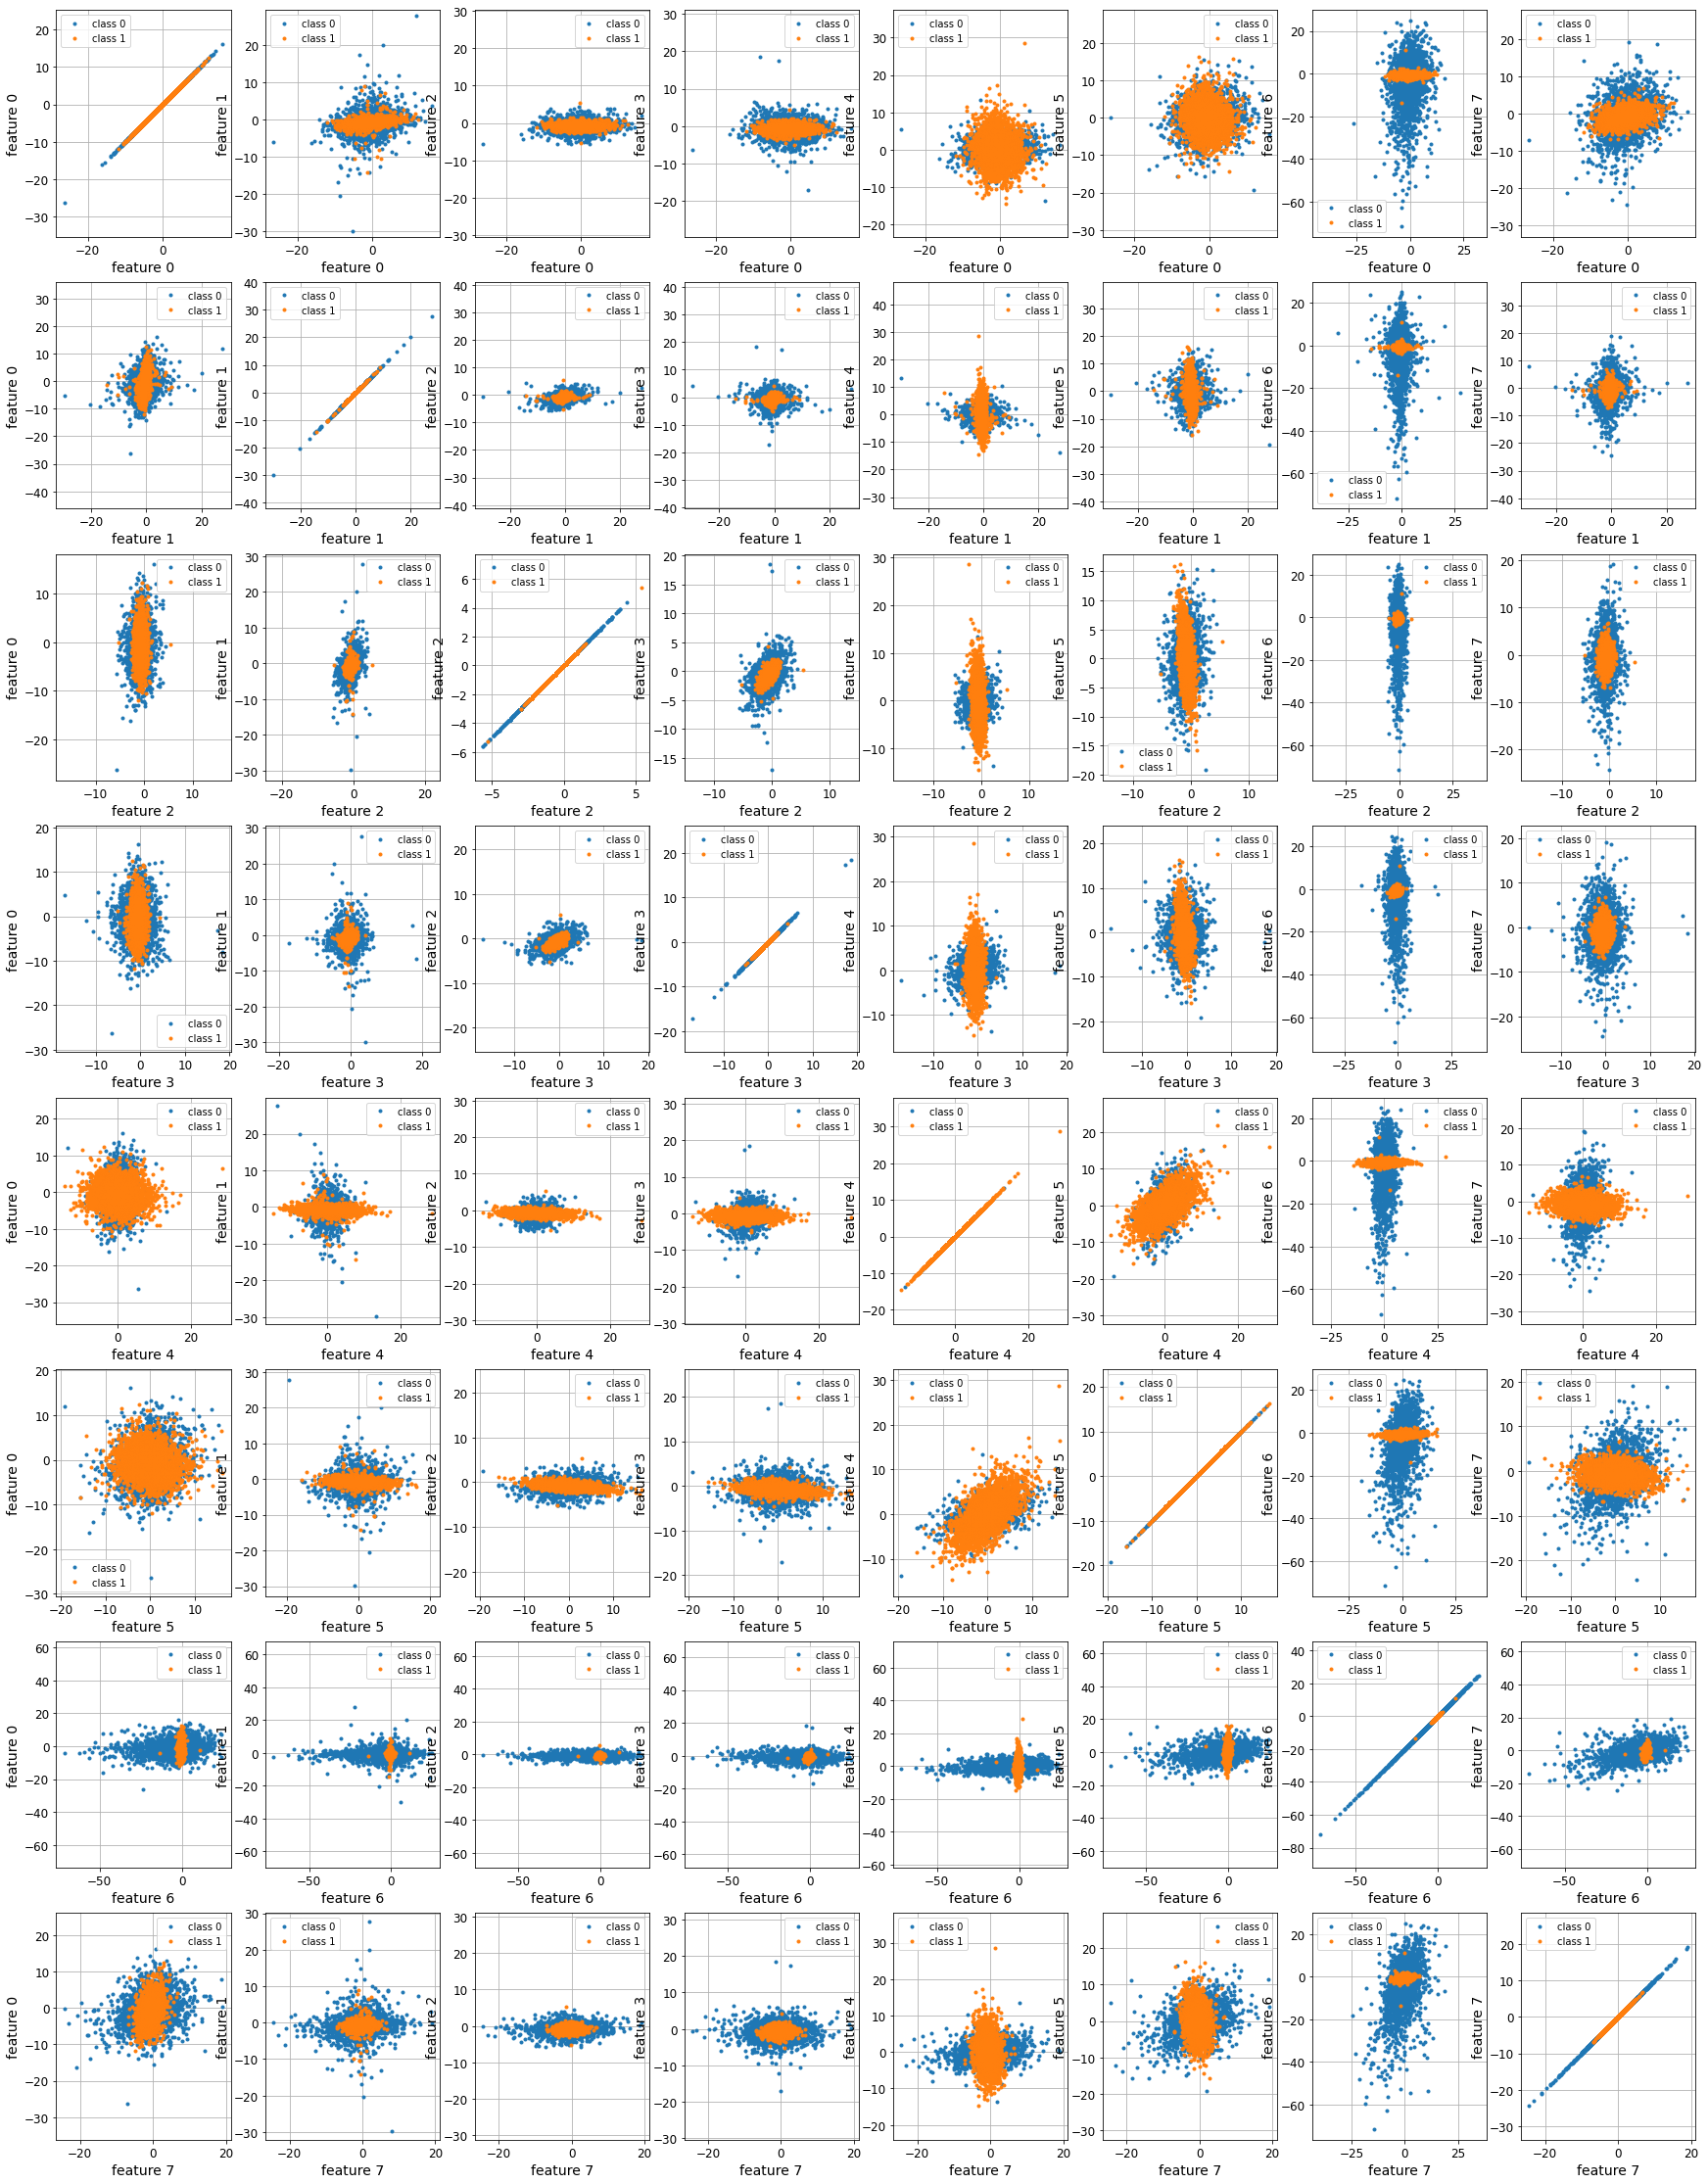

In [87]:
def subs2index(size,i,j) :
    a = np.arange(size*size).reshape((size,size))+1
    p = int(a[i,j])
    return p
 
figure = plt.figure(figsize=(30,40))
                    
for jj in range(8):
    for ii in range(8):
     ax=plt.subplot(8, 8, subs2index(8,ii,jj))
     plot_data(X_binary_avg,y_binary,ii,jj)

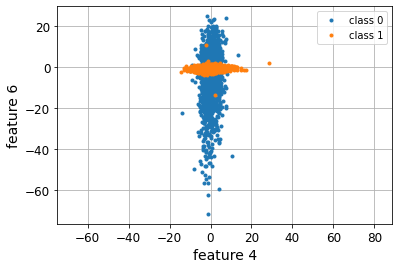

In [88]:
feat_1 = 4 #42 is obviously nonsense, replace by the correct feature
feat_2 = 6 # ensure that feat_1 < feat_2
# YOUR CODE HERE
#raise NotImplementedError()
plot_data(X_binary_avg, y_binary, feat_1, feat_2)

**1.08)** We can also use an auto-generated decision tree to help us decide on the must informative features.

In [89]:
X_simple_train, X_simple_test, y_simple_train, y_simple_test = train_test_split(X_binary_avg, y_binary, test_size=0.25, random_state=0)

from sklearn.tree import DecisionTreeClassifier
dt_clf_simple = DecisionTreeClassifier(random_state=0, max_depth=3)
dt_clf_simple.fit(X_simple_train, y_simple_train)
dt_y_simple_pred = dt_clf_simple.predict(X_simple_test)

print_accuracy_confusion(y_simple_test, dt_y_simple_pred, 'dt_simple')

dt_simple accuracy score: 0.9044016506189821
dt_simple confusion matrix:
 [[615 113]
 [ 26 700]]


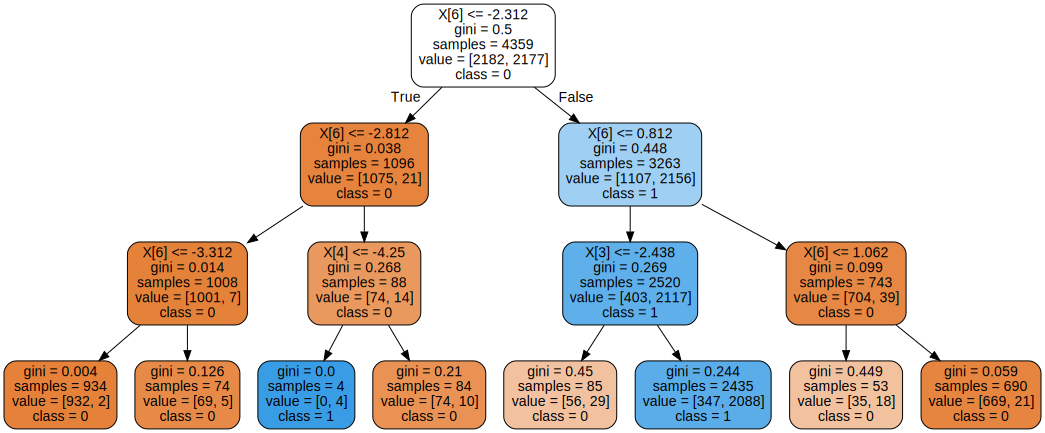

In [90]:
from sklearn import tree
import graphviz 
dot_data = tree.export_graphviz(dt_clf_simple, out_file=None, filled=True, rounded=True, class_names=['0', '1'])  
graph = graphviz.Source(dot_data) 
graph

Hopefully you'll come to a similar conclusion than with manual inspection.

In [91]:
feat_1 = 4 #42 is obviously nonsense, replace by the correct feature
feat_2 = 6# ensure that feat_1 < feat_2
# YOUR CODE HERE
#raise NotImplementedError()

**1.09)** One of the features is clearly dominant. Which other feature to use is a bit less clear cut. In any case, to select the other one, use the one with the lower number. We are next going to look at SVMs. Those work best with small to medium data sets.

Create a new subset of the averaged data (`X_binary_subset` and `y_binary_subset`) containing only the 2 features you chose and only every 3rd sample.

In [92]:
X_binary_subset=X_binary_avg[0:5813:3,[3,6]]
y_binary_subset=y_binary[0:5813:3]

#raise NotImplementedError()

[0 0 0 ... 1 1 1]


In [168]:
assert X_binary_subset.shape[0] == 1938
assert y_binary_subset.shape[0] == 1938
assert X_binary_subset.shape[1] == 2
assert X_binary_subset[0,0] == 0.5
assert X_binary_subset[1937,0] == -0.375
assert y_binary_subset[1937] == 1

In [94]:
#if you are stuck here, uncomment the lines below to load variables

#npzfile = np.load('./get_unstuck/binary_subset.npz')
#X_binary_subset = npzfile['X_binary_subset']
#y_binary_subset = npzfile['y_binary_subset']

Again some setup of the data etc.

In [169]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_subset_train, X_subset_test, y_subset_train, y_subset_test = train_test_split(X_binary_subset, y_binary_subset, test_size=0.25, random_state=0)

axes_subset = np.array([X_binary_subset[:, 0].min() - 1, X_binary_subset[:, 0].max() + 1, X_binary_subset[:, 1].min() - 1, X_binary_subset[:, 1].max() + 1])


**1.10)** Here is a random forest classifier to see how well we can still perform on this very reduced dataset.

rf accuracy score: 0.9010309278350516
rf confusion matrix:
 [[221  26]
 [ 22 216]]


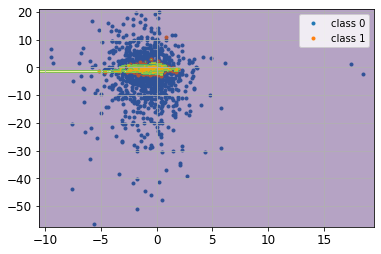

In [96]:
# Defining and fitting mutliple classifiers
from sklearn.ensemble import RandomForestClassifier

rf_clf_subset = RandomForestClassifier(random_state=0)
rf_clf_subset.fit(X_subset_train, y_subset_train)

# Predicting the Test set results
rf_y_subset_pred = rf_clf_subset.predict(X_subset_test)

print_accuracy_confusion(y_subset_test, rf_y_subset_pred, 'rf')
plot_feature_space_function(rf_clf_subset.predict, X_binary_subset, y_binary_subset, axes_subset)

**1.11)** We can still do surprisingly well compared to the full dataset, even though we have drastically reduced the number of features.

Now create an non-linear SVM classifier `svm_clf_subset` that beats the random forest classifier in terms of accuracy.

svm accuracy score: 0.934020618556701
svm confusion matrix:
 [[227  20]
 [ 12 226]]


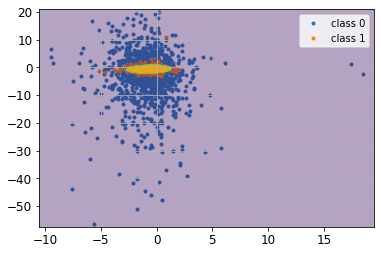

In [97]:
from sklearn.svm import  NuSVC

svm_clf_subset = NuSVC(gamma='auto')
svm_clf_subset.fit(X_subset_train, y_subset_train)
svm_y_subset_pred=svm_clf_subset.predict(X_subset_test)
#raise NotImplementedError()

print_accuracy_confusion(y_subset_test, svm_y_subset_pred, 'svm')
plot_feature_space_function(svm_clf_subset.predict, X_binary_subset, y_binary_subset, axes_subset)

In [98]:
assert accuracy_score(y_subset_test, svm_y_subset_pred) > 0.90103

### 2) Re-implemeting a linear SVM classifier
Next we are going to re-implement a linear SVM. As the data above can clearly not be separated by a linear decision boundary, we'll transform it once more. This obviously does not remove the overlap of the classes. Finally, the definition of an SVM expects labels/targets with -1 for one class and +1 for the other, so we also change the labels accordingly.

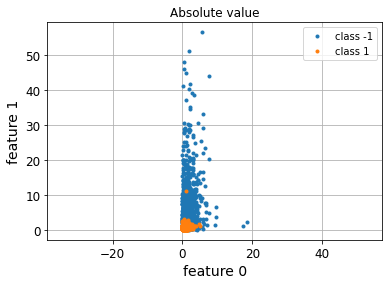

In [99]:
X_lin = np.abs(X_binary_subset)
y_lin = 2.*y_binary_subset - 1.

plot_data(np.abs(X_lin), y_lin, 0, 1, -1, 1)
plt.title('Absolute value')

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_lin, y_lin, test_size = 0.25, random_state = 0)

axes = np.array([X_lin[:, 0].min() - 1, X_lin[:, 0].max() + 1, X_lin[:, 1].min() - 1, X_lin[:, 1].max() + 1])

**2.01)** Before testing SVMs, let's see how well linear classifiers do now...

sgd accuracy score: 0.845360824742268
sgd confusion matrix:
 [[228  19]
 [ 56 182]]


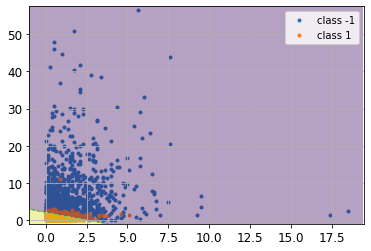

In [101]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=0)
sgd_clf.fit(X_train, y_train);
sgd_y_pred = sgd_clf.predict(X_test)
print_accuracy_confusion(y_test, sgd_y_pred, 'sgd')
plot_feature_space_function(sgd_clf.predict, X_lin, y_lin, axes, -1 ,1)

Actually a lot better than on the initial dataset...

**2.02)** Now, before implementing an SVM, let's test with an sklearn linear SVM (using a linear kernel achieves the same as using LinearSVC, but this way of doing it gives us access to the support vectors). We'll compare our own implementation to this one later on.

lin_svm accuracy score: 0.8907216494845361
lin_svm confusion matrix:
 [[202  45]
 [  8 230]]


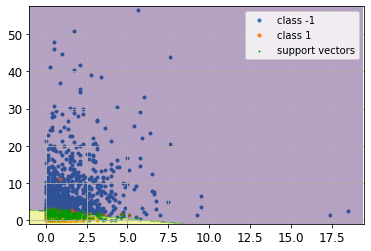

In [102]:
from sklearn.svm import SVC
lin_svm_clf = SVC(kernel="linear", C=2)
lin_svm_clf.fit(X_train, y_train)
lin_svm_y_pred = lin_svm_clf.predict(X_test)

print_accuracy_confusion(y_test, lin_svm_y_pred, 'lin_svm')
plot_feature_space_function(lin_svm_clf.predict, X_lin, y_lin, axes, -1, 1)
svs = lin_svm_clf.support_vectors_
plt.scatter(svs[:, 0], svs[:, 1], s=1, facecolors='#009900', label='support vectors')
plt.legend()

**2.03)** Is the data linearly separable?
Do we hence use a hard margin or a soft margin SVM?

In [103]:
#uncomment the correct answers

linearly_separable = 'yes'
#linearly_separable = 'no'

#SVM_margin = 'hard'
SVM_margin = 'soft'

# YOUR CODE HERE
#raise NotImplementedError()

**2.04) Linear SVM implementation:**  We are using CVXOPT to solve the Quadratic Programming (QP) problem. According to https://cvxopt.org/userguide/coneprog.html#quadratic-programming the optimization problem needs to be in the following form

$$\begin{array}[t]{ll}\mbox{minimize} & (1/2) x^TPx + q^T x \\\mbox{subject to} & Gx \preceq h \\ & Ax = b\end{array}$$

with the corresponding API
`cvxopt.solvers.qp(P, q[, G, h[, A, b[, solver[, initvals]]]])`

The dual form of the **hard margin** linear SVM objective is (page 169 of the book)

$$\underset{\alpha}{\mbox{minimize}} \hspace{0.2cm} \frac{1}{2} \sum_{i}^m \sum_{j}^m \alpha^{(i)}\alpha^{(j)}t^{(i)}t^{(j)}\mathbf{x}^{(i)\mathsf{T}}\mathbf{x}^{(j)}  - \sum_{i=1}^m \alpha^{(i)}$$
$\begin{array} \\\mbox{subject to} & \alpha^{(i)} \geq 0 \\ & \sum_i^m \alpha^{(i)} t^{(i)} = 0\end{array}$

Rewriting the SVM objective in vector/matrix form, and changing the constraint to the correct form, we get

$$\hspace{1.3cm}\underset{\alpha}{\mbox{minimize}} \hspace{0.4cm} \frac{1}{2} \boldsymbol{\alpha}^{\mathsf{T}} \mathbf{H} \boldsymbol{\alpha} -  \mathbf{1}^{\mathsf{T}}\boldsymbol{\alpha}$$
$$\begin{array}\\\mbox{subject to} & -\boldsymbol{\alpha} \leq \boldsymbol{0} \\ & \mathbf{t}^{\mathsf{T}}\boldsymbol{\alpha} = 0 \end{array}$$
where matrix $\mathbf{H}$ has elements $H_{i,j} = t^{(i)}t^{(j)}\mathbf{x}^{(i)\mathsf{T}}\mathbf{x}^{(j)}$

<!-- we additionally know that $\sum_i^m \alpha^{(i)} t^{(i)} = 0 $ (page 763) which can be rewritten to $\ \mathbf{t}^{\mathsf{T}}\boldsymbol{\alpha} = 0 $ -->

Map the terms from the SVM objective to the CVXOPT syntax

In [104]:
# use 'alpha', 'H', 't transposed', 'ones', 'identity', 'zero', 'zeros'
# for negtive values '-alpha' etc.
x = 'alpha'
P = 'H'
q = '-ones(1xlength(alpha))'
G = '-identity(length(alpha)xlength(alpha))'
h = 'zeros(length(alpha)x1)'
A = 't transposed'
b = 'zero'
# YOUR CODE HERE
#raise NotImplementedError()

**2.05)** For the **soft margin** linear SVM the constraint changes to $C \geq \alpha^{(i)} \geq 0$ so we get
$$
\begin{aligned}
    \min_{\alpha} & \frac{1}{2} \boldsymbol{\alpha}^{\mathsf{T}} \mathbf{H} \boldsymbol{\alpha} -  \mathbf{1}^{\mathsf{T}}\boldsymbol{\alpha}
    \\
     \textrm{subject to } & -\boldsymbol{\alpha} \leq \boldsymbol{0} 
    \\
     & \boldsymbol{\alpha} \leq \boldsymbol{C}
     \\
     & \mathbf{t}^{\mathsf{T}}\boldsymbol{\alpha} = 0  
\end{aligned}$$
where the two inequalities can be stacked in a combined matrix/vector `G` and `h`.


**2.06)** Before feeding all of this information to CVXOPT to optimize a **soft margin** SVM with our data, the only remaining question has to be answered: "How can we efficiently calculate $\mathbf{H}$?" Let's consider a simple example with 2 samples $\{x^{(1)}, x^{(2)}\} \in \mathbb{R}^2$ which are two dimensional vectors. i.e. $\mathbf{x}^{(1)} = (x_1^{(1)} , x_2^{(1)})^\mathsf{T}$

$$X = \begin{bmatrix} x_1^{(1)} & x_2^{(1)} \\ x_1^{(2)} & x_2^{(2)} \end{bmatrix} \ \ \ t = \begin{bmatrix} t^{(1)}  \\ t^{(2)} \end{bmatrix}$$

We now proceed to create a new matrix $\mathbf{X}'$ where each input sample $\mathbf{x}$ is multiplied by the corresponding output label $t$. This can be done easily in Numpy using vectorization and padding.

$$\mathbf{X}' = \begin{bmatrix} x^{(1)}_1 t^{(1)} & x^{(1)}_2t^{(1)} \\
x^{(2)}_1t^{(2)} & x^{(2)}_2t^{(2)} \end{bmatrix}$$

Finally we take the matrix multiplication of $\mathbf{X}'$ and its transpose giving

$$\mathbf{H} = {\mathbf{X}'} {\mathbf{X}'^\mathsf{T}} = \begin{bmatrix} x^{(1)}_1 t^{(1)} & x^{(1)}_2t^{(1)} \\
x^{(2)}_1t^{(2)} & x^{(2)}_2t^{(2)} \end{bmatrix} \begin{bmatrix} x^{(1)}_1 t^{(1)} & x^{(2)}_1 t^{(2)}  \\
x^{(1)}_2t^{(1)} & x^{(2)}_2t^{(2)} \end{bmatrix}$$

$$\mathbf{H} = \begin{bmatrix}  x^{(1)}_1 x^{(1)}_1t^{(1)}t^{(1)} + x^{(1)}_2x^{(1)}_2t^{(1)}t^{(1)} & x^{(1)}_1 x^{(2)}_1t^{(1)}t^{(2)} + x^{(1)}_2x^{(2)}_2t^{(1)}t^{(2)} \\ x^{(2)}_1 x^{(1)}_1t^{(2)}t^{(1)} + x^{(2)}_2x^{(1)}_2t^{(2)}t^{(1)} & x^{(2)}_1 x^{(2)}_1t^{(2)}t^{(2)} + x^{(2)}_2x^{(2)}_2t^{(2)}t^{(2)} \end{bmatrix}$$

#### 2.07) Install cvxopt ####
The `tf2` environment does not include a solver for QPs. So we need to install an additional package. This is easy to do on a command line with
`conda install --channel "conda-forge" cvxopt` (do not forget to activate the `tf2` environment before running the command)

**2.08) Begin implementation:** Let's import <code>cvxopt</code>, define a soft margin weight <code>C</code>, and get the dimensionality of our training data <code>mxn</code>.

In [105]:
#Importing with custom names to avoid issues with numpy / sympy matrix
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

#Initializing values
C = 2
m,n = X_train.shape

**2.09)** Following the hints from 2.06) calculate <code>H</code>.

In [106]:

svm_y_train              = y_train.copy()
svm_y_train[y_train ==0] =-1
size                     = len(svm_y_train)
X_prime                  = X_train*svm_y_train.reshape((-1,1))
H                        = X_prime @ X_prime.T
# YOUR CODE HERE
#raise NotImplementedError()

In [107]:
assert H.shape[0] == 1453
assert H.shape[1] == 1453
assert H[0,0] == 1.265625
assert H[-1,-1] == 0.5625

**2.10)** Calculate/define <code>P</code>, <code>q</code>, <code>G</code>, <code>h</code>, <code>A</code> and <code>b</code>.

In [108]:
P = H
q = -np.ones((size,1))
G = np.vstack((-1*np.identity(size),np.identity(size)))
h = np.squeeze(np.vstack((np.zeros((size,1)),np.ones((size,1))*C)))
A = svm_y_train.reshape((1,-1))
b = np.array([0.])

# YOUR CODE HERE
#raise NotImplementedError()

In [109]:
assert P.shape[0] == 1453
assert P.shape[1] == 1453

assert q.shape[0] == 1453
assert q.shape[1] == 1
assert q[0,0] == -1

assert G.shape[0] == 2906
assert G.shape[1] == 1453
assert G[-1,-1] == 1.0

assert h.shape[0] == 2906
assert h.ndim == 1
assert h[0] == 0.0

assert A.shape[0] == 1
assert A.shape[1] == 1453
assert A[0,0] == 1.0

assert b.shape[0] == 1
assert b.ndim == 1


In [110]:
#if you are stuck here, uncomment the lines below to load variables

#npzfile = np.load('./get_unstuck/cvxopt.npz')
#P = npzfile['P']
#q = npzfile['q']
#G = npzfile['G']
#h = npzfile['h']
#A = npzfile['A']
#b = npzfile['b']

**2.11)** Now we are almost ready to run the solver...

In [111]:
#Converting into cvxopt format
P = cvxopt_matrix(P)
q = cvxopt_matrix(q)
G = cvxopt_matrix(G)
h = cvxopt_matrix(h)
A = cvxopt_matrix(A)
b = cvxopt_matrix(b)

#Setting solver parameters 
cvxopt_solvers.options['show_progress'] = True
cvxopt_solvers.options['abstol'] = 1e-10
cvxopt_solvers.options['reltol'] = 1e-10
cvxopt_solvers.options['feastol'] = 1e-10

**2.12)** Run the solver and store the results in `sol`

In [112]:
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
# YOUR CODE HERE
#raise NotImplementedError()
alphas = np.array(sol['x'])

     pcost       dcost       gap    pres   dres
 0: -1.5694e+03 -2.1233e+04  2e+05  4e+00  4e-12
 1: -1.1521e+03 -1.7430e+04  4e+04  9e-01  4e-12
 2: -9.2263e+02 -1.0562e+04  2e+04  3e-01  2e-12
 3: -7.5552e+02 -4.3660e+03  5e+03  9e-02  8e-13
 4: -6.9899e+02 -1.8473e+03  1e+03  2e-02  3e-13
 5: -7.6343e+02 -1.1777e+03  5e+02  6e-03  2e-13
 6: -7.9309e+02 -1.0980e+03  3e+02  4e-03  2e-13
 7: -8.1903e+02 -1.0283e+03  2e+02  2e-03  2e-13
 8: -8.3628e+02 -9.8890e+02  2e+02  1e-03  2e-13
 9: -8.5314e+02 -9.5083e+02  1e+02  8e-04  2e-13
10: -8.6534e+02 -9.2639e+02  6e+01  4e-04  3e-13
11: -8.7401e+02 -9.0749e+02  3e+01  1e-04  3e-13
12: -8.7731e+02 -9.0166e+02  2e+01  8e-05  3e-13
13: -8.8114e+02 -8.9542e+02  1e+01  4e-05  3e-13
14: -8.8402e+02 -8.9125e+02  7e+00  2e-05  3e-13
15: -8.8562e+02 -8.8881e+02  3e+00  4e-06  3e-13
16: -8.8635e+02 -8.8786e+02  2e+00  1e-06  3e-13
17: -8.8695e+02 -8.8718e+02  2e-01  1e-07  3e-13
18: -8.8706e+02 -8.8706e+02  6e-03  3e-09  3e-13
19: -8.8706e+02 -8.87

In [113]:
assert isinstance(sol, dict)
assert 'primal objective' in sol.keys()
assert alphas.shape[0] == 1453


**2.13)** Calculate `w_svm` and `b_svm` (see page 169)

In [115]:
#==================Computing parameters===============================#
# Use a threshold of 1e-4 for alpha (rather than 0) for computing b_svm

w_svm = np.sum((X_train*alphas*svm_y_train[:,np.newaxis]),axis=0)
mask = np.squeeze(alphas>10**-4)
svm_y_train[mask]
b_svm = np.sum(svm_y_train[mask] - w_svm[np.newaxis,:]@X_train[mask,:].T)/len(alphas[mask,:])
# YOUR CODE HERE
#raise NotImplementedError()
# Display results
w_svm = w_svm.flatten()
print('w = ', w_svm)
print('b = ', b_svm)

w =  [-0.42666667 -1.06666667]
b =  2.061274725242967


In [116]:
assert np.abs(w_svm[0] - -0.42666667) < 1e-6
assert np.abs(b_svm - 2.06127472524322) < 1e-6


**2.14)** Implement the SVC prediction (see page 165)

In [171]:

def own_svm_predict(b,w,X):
    prediction = w@X.T + b
    prediction[prediction >=0] = 1
    prediction[prediction<0]   = -1
    return prediction

# YOUR CODE HERE
#raise NotImplementedError()

In [118]:
assert (own_svm_predict(1, np.array([2, 3]), np.array([[4, 5], [-5, 0]])) == np.array([1, -1])).all()
assert (own_svm_predict(-1, np.array([0, 1]), np.array([[-5, 0], [1, 0]])) == np.array([-1, -1])).all()

own_svm accuracy score: 0.8948453608247423
own_svm confusion matrix:
 [[219  28]
 [ 23 215]]


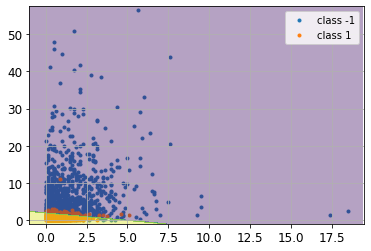

In [119]:
own_svm_y_pred = own_svm_predict(b_svm,w_svm,X_test)
print_accuracy_confusion(y_test, own_svm_y_pred, 'own_svm')

# A few lines to make own_svm_predict work with plot_feature_space_function (without implementing a fullblown sklearn calssifier)
import functools
own_svm_predict_param = functools.partial(own_svm_predict, b_svm, w_svm)

plot_feature_space_function(own_svm_predict_param, X_lin, y_lin, axes, -1, 1)

**2.14)** Let's compare our solution to the one from sklearn

w =  [[-0.42697222 -1.06654914]]
b =  [2.49401716]
lin_svm accuracy score: 0.8907216494845361
lin_svm confusion matrix:
 [[202  45]
 [  8 230]]


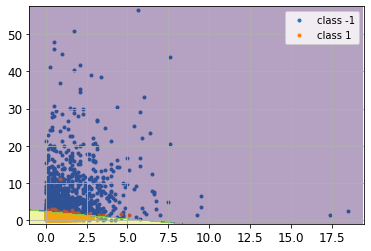

In [120]:
print('w = ',lin_svm_clf.coef_)
print('b = ',lin_svm_clf.intercept_)

print_accuracy_confusion(y_test, lin_svm_y_pred, 'lin_svm')
plot_feature_space_function(lin_svm_clf.predict, X_lin, y_lin, axes, -1, 1)

Both the accuracy and the `w` parameter values should be close. Small differences occur depending on how the optimization is done (e.g., tolerances). As pointed out on page 763, there are multiple ways for calculating `b`. The book proposes to use the average rather than a single value. If we just use the first value instead, we are a lot closer to the sklearn parameter.

If you are interested in how this method is modified to build non-linear SVMs using the *kernel trick*, read pages 168 -172 of the book.

linear SVM implementation based on https://xavierbourretsicotte.github.io/SVM_implementation.html

### 3) Voting classifier

We already tried quite a few classifiers on this data set. Let's try to combine them in an ensemble (chapter 7 of the book).

First we'll define two more classifiers for the ensemble.

rf accuracy score: 0.8701030927835052
rf confusion matrix:
 [[210  37]
 [ 26 212]]


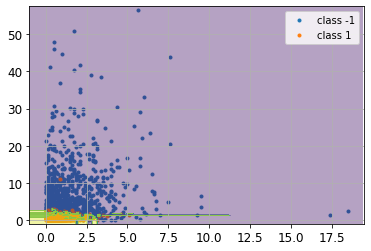

In [121]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
rf_y_pred = rf_clf.predict(X_test)
print_accuracy_confusion(y_test, rf_y_pred, 'rf')
plot_feature_space_function(rf_clf.predict, X_lin, y_lin, axes, -1, 1)

knn accuracy score: 0.8865979381443299
knn confusion matrix:
 [[204  43]
 [ 12 226]]


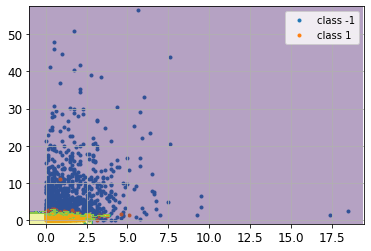

In [122]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(5)
knn_clf.fit(X_train, y_train)
knn_y_pred = knn_clf.predict(X_test)
print_accuracy_confusion(y_test, knn_y_pred, 'knn')
plot_feature_space_function(knn_clf.predict, X_lin, y_lin, axes, -1, 1)

**3.01)** Combine the predictions of the SGD classifier `sgd_clf` (we implemented before looking into how to implement a linear SVM), the random forest `rf_clf`, and of the KNN `knn_clf` in one variable `combined_pred`.

In [172]:
combined_pred =np.vstack((sgd_clf.predict(X_test),rf_clf.predict(X_test),knn_clf.predict(X_test)))
#raise NotImplementedError()

In [124]:
assert combined_pred.shape[0] == 3
assert combined_pred.shape[1] == 485

**3.02)** Implement hard voting, i.e., generate a new variable `hard_voting_pred` where the prediction corresponds to that of the majority of the classifiers.

In [125]:
# hint: use a `mode` function from scipy
import scipy

hard_voting_pred = np.squeeze(scipy.stats.mode(combined_pred,axis=0)[0][:])
# YOUR CODE HERE
#raise NotImplementedError()
print_accuracy_confusion(y_test, hard_voting_pred, 'hard_voting')


hard_voting accuracy score: 0.8927835051546392
hard_voting confusion matrix:
 [[215  32]
 [ 20 218]]


In [126]:
assert hard_voting_pred.shape[0] == 485
assert hard_voting_pred.shape[1] == 1 or hard_voting_pred.ndim == 1
assert accuracy_score(y_test, hard_voting_pred) > 0.8927

IndexError: tuple index out of range

**3.03)** Even this very simple voting approach brings the 3 classifiers that don't perform that well individually to the same level as your best performing classifier we had so far, the linear SVM.

#### 3.04) Bagging 
Now let's see what we can do with an ensemble of just our worst performing classifier, the SGD. The code is already provided below, your task is to adjust the parameters such that it beats the linear SVM by getting an accuracy >0.9

In [127]:
# Bagging
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier

n_estimators=100
max_samples=600
bootstrap=False

# YOUR CODE HERE
#raise NotImplementedError()

bag_clf = BaggingClassifier(SGDClassifier(random_state=0),
                            n_estimators=n_estimators,
                            max_samples=max_samples, 
                            bootstrap=bootstrap, 
                            random_state=0)

bag_clf.fit(X_train, y_train)
bag_y_pred = bag_clf.predict(X_test)

print_accuracy_confusion(y_test, bag_y_pred, 'bag')

bag accuracy score: 0.9030927835051547
bag confusion matrix:
 [[210  37]
 [ 10 228]]


In [128]:
assert accuracy_score(y_test, bag_y_pred) > 0.9

### 4) Imitation Learning for Motion Planning

In the last section of this practicum, we will use our machine learning knowledge in a robotics example.

#### Motion Planning
Motion planning is a field of robotics in which robots have to plan and execute a trajectory in order to reach a goal. The following image shows a manipulator reaching a goal while avoiding obstacles.

<img src="img/manipulator_motion.png" alt="drawing" width="400"/>

Commonly, these algorithms have to be designed and tunned by someone with knowledge in robotics and/or control. However, if we aim to have robots in our daily life outside industrial settings, such an approach becomes limiting, because it is not be feasible to have a roboticist tunning every robot for every different situation.

#### Imitation Learning
Imitation Learning is a promising line of research that could address this problem. Imitation Learning can give humans, that are not experts in robotics/control, the ability to program a robot. The idea is simple, a human provides a set of demontrations of a task, and a robot imitates her/him.

#### Goal

Build a Motion Planning algorithm that uses an Imitation Learning technique, called Behavioral Cloning, to fit a classifier, using Supervised Learning, to demonstrations provided by an *oracle*.

* **Oracle:** a system that provides demonstrations of a task. In our motivation of the problem the oracle is a human; however, for practical reasons, in this assignment we are going to use a Motion Planning algorithm (Artificial Potential Fields, implementation from https://pythonrobotics.readthedocs.io/en/latest/modules/path_planning.html#potential-field-algorithm) as an oracle, and given that we are going to imitate its behavior, it is not required for you to know how this method works.

In [129]:
from potential_field_planning import create_environment, potential_field_planning, classifier_planning, plot_environment
import numpy as np
import matplotlib.pyplot as plt

**4.01)** The function `create_environment` randomly generates a 2D environment that consists of a starting point `[sx, sy]`, a goal `[gx, gy]`, and obstacles `[ox, oy]`. The dimensionality of `ox` and `oy` is equal to the number of obstacles. 

Let's create an environment with one obstacle.

*Note: this function only supports 1, 2 or 3 obstacles.*

In [130]:
env = create_environment(n_obstacles=1, seed=1)

print('Start              :', [env.sx, env.sy])
print('Goal               :', [env.gx, env.gy])
print('Obstacles x-coords  :', env.ox)
print('Obstacles y-coords  :', env.oy)
print('Number of obstacles:', len(env.ox))

Start              : [0.0008006237214142065, 2.1163280084228786]
Goal               : [5.605211980728757, 6.777831030035783]
Obstacles x-coords  : [3.08511002351287]
Obstacles y-coords  : [4.60162246721079]
Number of obstacles: 1


**IMPORTANT:** do not modify the seed values.

The function `potential_field_planning` is the oracle. It takes as input the parameters of our environment and generates a collision-free path to the goal. The generated trajectory is saved in `trajectory`.

The function `plot_environment` can be used to visualize the environment, namely the obstacles (blue circles), start and goal position, and the trajectory.

**4.02)** Let's generate a trajectory with the oracle and visualize it:

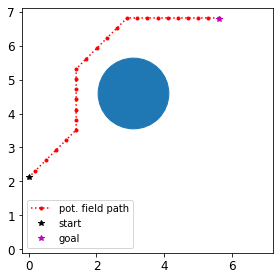

In [131]:
# Generate trajectory
trajectory = potential_field_planning(env)

# Show environment and trajectory
plot_environment(env, potential_field_trajectory=trajectory)

#### 4.03) Dataset

We can get trajectories from our oracle in multiple environments to build a dataset to train a classifier.


**Input:** In this context, the input of our machine learning model corresponds to the *robot's state* at a specific moment in time of the environment. Each one of these *moments* are known as time steps, and for every time step, as a function of the robot's state, our machine learning method has to take make a decision on where to go next. 

**robot's state** = [gxd, gyd, oxd1,...,oxdn, oyd1, ..., oydn]

* **gxd**:  x distance from robot to goal
* **gyd**:  y distance from robot to goal
* **oxdi**: x distance from robot to obstacle i
* **oydi**: y distance from robot to obstacle i

**Output:** We are going to solve this problem as a classification problem. Each class corresponds to an *action* that the robot can take i.e., where to go next. These classes are represented using a vector that indicates the directions in which the robot can move.

**actions** = north, east, south, west, north-east, north-west, south-east, south-west. Represented with numbers from 0 to 7 respectively.

**4.03)** `trajectory` is a dictionary that contains the following information:
* `state`: the set of states visited by the robot. Each row of the state vector corresponds to the state of the robot in a specific time step. 
* `action`: the set of actions taken by the robot in every time step.
* `pos`: the positions that the robot visited, as visualized in the plot.
* `success`: a boolean indicating if the goal state was reached
* `collision`: a boolean indicating if the robot collided.

These names can be used as keys to access the data in the dictionary. 

Get the states and actions from `trajectory`.

In [132]:
state = trajectory['state']
actions = trajectory['action']
# YOUR CODE HERE

#raise NotImplementedError()

In [133]:
assert np.abs(state[0, 1] - -4.66150302) < 1e-6
assert np.abs(state[4, 3] - -1.38529445) < 1e-6
assert np.abs(state[10, 2] - -1.68430939) < 1e-6


**4.04)** As mentioned before, the dimensionality of our state vector is a function of the number of obstacles in the environment. 

Build a function that computes the state dimensionality as a function of n obstacles:

*Note: this function has to be solved with an equation.*

In [134]:
def get_state_dim(n_obstacles):
    state_dim = 2*n_obstacles+2
    # YOUR CODE HERE
    #raise NotImplementedError()
    return state_dim

In [135]:
assert get_state_dim(2) == 6
assert get_state_dim(4) == 10


**4.05)** Build a function called `generate_dataset` that repeats the following process n times:

    1) Create an environment.

    2) Get a demonstration from the oracle.

    3) Save demonstration, i.e., append visited states into an array called states and taken actions into an 
    array called actions.

The argument `n_obstacles` indicates the number of obstacles the created environments will have, `n_trajectories` corresponds to the number of times the loop above will be repeated, and `show` is a boolean that makes the saved trajectories visible when true.

Wherever it says `MODIFY`, you should modify the code.

In [136]:
import ipywidgets

def generate_dataset(n_obstacles, n_trajectories, show=True):
    # Reproducibility, do not change
    np.random.seed(18)  # reproducibility, do not change
    
    # Initialize our arrays
    states = np.empty([0, get_state_dim(n_obstacles)])
    actions = np.empty([0])
    
    if show:
        # Create lists used for interactive animation
        envs = []
        trajectories = []
       
    for i in range(n_trajectories):            
        # Create environment
        seed = np.random.randint(low=0, high=1e6)  # use this seed to create the environment
        env  = create_environment(n_obstacles=n_obstacles, seed=seed)  # MODIFY
        # YOUR CODE HERE
        #raise NotImplementedError()
        
        # Run planner and get a trajectory
        trajectory = potential_field_planning(env)  # MODIFY
        # YOUR CODE HERE
        #raise NotImplementedError()
        
        if show:
            # Store generated data for use in interactive animation
            envs.append(env)
            trajectories.append(trajectory)

        # Append data to arrays states and actions. 
        states= np.vstack((states,trajectory['state'])) # MODIFY, not None because it already exists
        actions=np.append(actions,trajectory['action']) # MODIFY, not None because it already exists
        # YOUR CODE HERE
        #raise NotImplementedError()
        
        # Print progress
        if (i + 1) % (n_trajectories // 5 + 1e-6) == 0:
            print('Progress dataset: %d %%' % ((i + 1) / n_trajectories * 100))

    if show:
        # Generate an interactive ipython widget to visualize the generated environments and trajectories
        def plot_train_track(i):
            plot_environment(envs[i], potential_field_trajectory=trajectories[i])
            plt.title(f'dataset trajectory {i}')
        ipywidgets.interact(plot_train_track, i=(0,n_trajectories - 1))
    
    return states, actions

Create a dataset with 5 trajectories and 1 obstacle.

In [137]:
states, actions = generate_dataset(n_obstacles=1, n_trajectories=5, show=True)
print(np.shape(actions))

interactive(children=(IntSlider(value=2, description='i', max=4), Output()), _dom_classes=('widget-interact',)…

(77,)


In [138]:
assert actions.shape == (77,)
assert states.shape == (77, 4)
assert np.abs(states[43, 3] - -0.142548887) < 1e-6
assert int(actions[60]) == 7


#### 4.06) Prepare data

After collecting a dataset, it is necessary to prepare the data for training.

**4.07)** In the collected dataset, the values `states[i, :]`, `states[i+1, :]` and `states[i+2, :]` are correlated (in most of the cases), because they are state transitions obtained in the same demonstration. This brakes an important machine learning assumption, which one? 

In [139]:
# Uncomment the correct answer

#answer = 'the dataset is big and diverse enough, so our input space is properly represented'
#answer = 'the data has a linear relationship'
answer = 'the data is i.i.d'
#answer = 'the kernel trick'

# YOUR CODE HERE
#raise NotImplementedError()

This problem is alleviated when we randomly sample from our dataset during training; however, we have to be careful to shuffle the dataset before splitting it into training and test; otherwise, the data in these sets will be highly correlated.

In [140]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

**4.07)** Using the above imported functions, build the function `data_preprocess`, which takes as an argument the `states` and `actions` arrays generated with `generate_dataset` function.

In [141]:
def data_preprocess(states, actions): 
    # Shuffle data with random_state=0
    shuffled_states, shuffled_actions = shuffle(states,actions,random_state=0)  # MODIFY
    # YOUR CODE HERE
    #raise NotImplementedError()

    # Separate data into train and test (20% of the data for test set with random_state=0)
    states_train, states_test, actions_train, actions_test = train_test_split(shuffled_states, shuffled_actions, test_size=0.2, random_state=0)
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    # Scale training and test data (remember that test data should never be used to fit data)
    scaler              = StandardScaler()
    scaler.fit(states_train)
    states_train_scaled = scaler.transform(states_train)  # MODIFY
    states_test_scaled  = scaler.transform(states_test)   # MODIFY
    # YOUR CODE HERE
    #raise NotImplementedError()
    return states_train_scaled, states_test_scaled, actions_train, actions_test, scaler

In [142]:
#if you are stuck here, uncomment the lines below to load variables

#npzfile = np.load('./get_unstuck/states_actions.npz')
#states  = npzfile['states']
#actions = npzfile['actions']

states_train_scaled, states_test_scaled, actions_train, actions_test, scaler = data_preprocess(states, actions)


(61, 4)


**4.08)** Preprocess dataset

In [143]:
states_train_scaled, states_test_scaled, actions_train, actions_test, scaler = data_preprocess(states, actions)

In [144]:
assert states_train_scaled.shape == (61, 4)
assert states_test_scaled.shape == (16, 4)
assert actions_train.shape == (61,)
assert actions_test.shape ==(16,)
assert np.abs(states_train_scaled[10, 0] - 0.986126195) < 1e-6
assert np.abs(states_test_scaled[4, 3] - -0.129293968) < 1e-6
assert int(actions_train[43]) == 7
assert int(actions_test[3]) == 0


#### 4.09) Train classifier 
Build the function `train_classifier` that trains a classifier directly from `states` and `actions` and gets its accuracy score and confusion matrix.

In [145]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [173]:

def train_classifier(states, actions):
    # Prepare data
    states_train_scaled, states_test_scaled, actions_train, actions_test, scaler = data_preprocess(states, actions)
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    # Train Random Forest with random_state=0
    clf = RandomForestClassifier(random_state =0)  # MODIFY
    clf.fit(states_train_scaled,actions_train)
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    # Predict using test data
    actions_test_pred = clf.predict(states_test_scaled)  # MODIFY
    # YOUR CODE HERE
    #raise NotImplementedError()

    # Get accuracy score
    accuracy = accuracy_score(actions_test, actions_test_pred) # MODIFY
    # YOUR CODE HERE
    #raise NotImplementedError()

    # Plot confusion matrix
   
    conf_matrix = confusion_matrix(actions_test, actions_test_pred,np.array([0,1,2,3,4,5,6,7])) # MODIFY
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    print(f'Accuracy: {accuracy:.3f}')
    print('\nConfusion matrix:\n\n', conf_matrix)
    
    return clf, accuracy, conf_matrix, scaler

In [174]:
clf, accuracy, conf_matrix, scaler = train_classifier(states, actions)

Accuracy: 0.938

Confusion matrix:

 [[4 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 9]]


/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [148]:
assert np.abs(accuracy - 0.9375) < 1e-6
assert conf_matrix.shape == (8, 8)
assert conf_matrix[3, 3] == 2

**4.10)** There's something about the obtained confusion matrix that indicates that the state/input space of the learning problem is, probably, not properly covered. What is it?

In [149]:
# Uncomment the correct answer

#answer = 'it is not symmetrical'
#answer = 'it is sparse'
#answer = 'the sum of its elements is low'
#answer = 'it is not invertible'


In [150]:
answer='it is sparse'

#### 4.11) Generate trajectories
The classifier got a high accuracy, but we observed that the input/state space is not properly covered, let's see how it performs as a planner. 

The following function generates trajectories from a trained classifier and returns its success rate. 

* A trajectory is considered to be successful if it reaches the goal before a time limit and does not collide with any obstacle.

* The `classifier_planning` function was imported at the beginning of the file and it creates a path using a classifier in a random environment. It returns a dictionary called `trajectory` (similar to `potential_field_planning`) but additionaly you can use the `success` and `collision` keys to check if the goal was reached.

* If `show=True`, the function will show the classifier's trajectories in purple and the Artificial Potential Field planner trajectories in red.

In [151]:
def generate_trajectories_classifier(clf, scaler, n_obstacles, n_trajectories_test, show=True):
    success_counter = 0  # count the number of times the robot reached the goal
    np.random.seed(50)  # reproducibility 

    if show:
        envs = []
        trajectories = []
    
    for i in range(n_trajectories_test):
        seed = np.random.randint(low=0, high=1e6)
        
        # Create environment
        env = create_environment(n_obstacles=n_obstacles, seed=seed)
       
        # Generate trajectory
        trajectory = classifier_planning(env, clf, scaler)
        success = trajectory['success']
        
        if show:
            envs.append(env)
            trajectories.append(trajectory)

        # Count goal reached
        if success:
            success_counter += 1
            
        # Print if classifier fails
        if not success:
            print('Trial %i failed!' % i)
            
        # Print progress
        if (i + 1) % int(n_trajectories_test  / 5) == 0:
            print('Progress trials: %d %%' % ((i + 1) / n_trajectories_test * 100))
    
    success_rate = success_counter / n_trajectories_test
    print('\nSuccess rate: %.3f' % success_rate)
    
    if show:
        def plot_test_track(i):
            env = envs[i]
            success = trajectories[i]['success']
            collision = trajectories[i]['collision']

            pf_trajectory = potential_field_planning(env)
            plot_environment(env, potential_field_trajectory=pf_trajectory, classifier_trajectory=trajectories[i])
            plt.title(f'test trajectory {i}, success={success}, collision={collision}')
        ipywidgets.interact(plot_test_track, i=(0,n_trajectories_test-1))
    
    return success_rate

**4.11)** Carefully read this function and answer the questions.

**Q1:** What is the variable `n_trajectories_test`?

**Q2:** Why does the `classifier_planning` function needs the `scaler` in one of its inputs?

In [152]:
# For each question uncomment on of the answers

# Answer Q1

A1 = 'Number of environments to train the classifier'
#A1 = 'Number of environments to test the classifier'
#A1 = 'Number of environments in which the classifier was successful'
#A1 = 'Number of environments in which the classifier failed'

# YOUR CODE HERE
#raise NotImplementedError()

# Answer Q2
A2 = 'Because the environment has unscaled states, but the classifier expects scaled inputs'
#A2 = 'Because the environment has scaled states, but the classifier expects unscaled inputs'
#A2 = 'Because the classifier generates unscaled outputs, but the environment expects scaled actions'
#A2 = 'Because the classifier generates scaled outputs, but the environment expects unscaled actions'

# YOUR CODE HERE
#raise NotImplementedError()

**4.12)** Run the function `generate_trajectories_classifier` to get the success rate of the learned planner over **100 environments** with **one obstacle** and save it in the variable `suc_5t`.

In [153]:
#if you are stuck here, uncomment the lines below to load variables

# In this case it is required to have pickle installed in the tf2 environment: pip install pickle-mixin

#import pickle 
#with open('./get_unstuck/clf_fitted', 'rb') as config_dictionary_file:
#    config_dictionary = pickle.load(config_dictionary_file) 
    
#clf = config_dictionary['clf']
#scaler = config_dictionary['scaler']

In [154]:
suc_5t = generate_trajectories_classifier(clf, scaler,1, 100, show=True)  # MODIFY
# YOUR CODE HERE
#raise NotImplementedError()

Timeout!
Trial 2 failed!
Collision detected!
Trial 4 failed!
Timeout!
Trial 5 failed!
Timeout!
Trial 6 failed!
Timeout!
Trial 8 failed!
Timeout!
Trial 9 failed!
Timeout!
Trial 11 failed!
Timeout!
Trial 13 failed!
Timeout!
Trial 16 failed!
Timeout!
Trial 17 failed!
Timeout!
Trial 19 failed!
Progress trials: 20 %
Collision detected!
Trial 20 failed!
Timeout!
Trial 21 failed!
Collision detected!
Trial 22 failed!
Timeout!
Trial 23 failed!
Timeout!
Trial 26 failed!
Timeout!
Trial 27 failed!
Timeout!
Trial 28 failed!
Timeout!
Trial 29 failed!
Timeout!
Trial 30 failed!
Collision detected!
Trial 31 failed!
Timeout!
Trial 32 failed!
Timeout!
Trial 34 failed!
Timeout!
Trial 36 failed!
Timeout!
Trial 38 failed!
Timeout!
Trial 39 failed!
Progress trials: 40 %
Timeout!
Trial 40 failed!
Timeout!
Trial 41 failed!
Timeout!
Trial 43 failed!
Timeout!
Trial 44 failed!
Timeout!
Trial 47 failed!
Timeout!
Trial 49 failed!
Timeout!
Trial 52 failed!
Timeout!
Trial 53 failed!
Timeout!
Trial 54 failed!
Timeout!

interactive(children=(IntSlider(value=49, description='i', max=99), Output()), _dom_classes=('widget-interact'…

**4.13)** The success rate of the classifier is low, which indicates that the learned planner will fail to reach of the goal more than half of the times. Taking into consideration **4.10**, what should we try to increase the performance of our planner?

In [155]:
# Uncomment the correct answer

#answer = 'a different learning algorithm'
#answer = 'feature engineering'
#answer = 'filter outliers'
answer = 'increase the size of the dataset'

# YOUR CODE HERE
#raise NotImplementedError()

#### 4.14) Repeat experiment with different settings
Using the functions the we created so far in this section, a new function can be constructed to run the complete experiment with different settings using as arguments `n_obstacles`, `n_trajectories_dataset` and `n_trajectories_test`.

In [156]:
def run_experiment(n_obstacles, n_trajectories_dataset, n_trajectories_test, show=True):
    # Create database
    print('1) Create dataset: \n')
    states, actions = generate_dataset(n_obstacles, n_trajectories_dataset, show=show)

    # Train classifier
    print('\n2) Train classifier: \n')
    clf, accuracy, conf_matrix, scaler = train_classifier(states, actions)

    # Generate trajectories with classifier
    print('\n3) Test classifier: \n')
    success_rate = generate_trajectories_classifier(clf, scaler, n_obstacles, n_trajectories_test, show=show)
    return success_rate

**4.15)** Let's repeat the experiment with 20 trajectories in the dataset.

In [157]:
suc_20t = run_experiment(n_obstacles=1, n_trajectories_dataset=20, n_trajectories_test=100, show=True)

1) Create dataset: 



interactive(children=(IntSlider(value=9, description='i', max=19), Output()), _dom_classes=('widget-interact',…


2) Train classifier: 

[3. 3. 2. 5. 4. 7. 4. 4. 0. 7. 6. 5. 6. 4. 1. 7. 7. 3. 5. 6. 7. 1. 7. 3.
 7. 4. 3. 5. 7. 7. 0. 7. 4. 7. 7. 1. 5. 6. 3. 7. 3. 4. 1. 3. 6. 7. 3. 0.
 5. 5. 7. 2. 0. 7. 7. 7. 5. 4. 0. 5. 3. 7. 3. 0. 3. 6. 7. 0. 5. 7. 5. 7.
 3. 3. 5. 0. 0. 0. 7. 0. 3. 1. 3. 7. 0. 5. 4. 0. 7. 4. 4. 1. 7. 3. 1. 0.
 3. 5. 7. 7. 2. 7. 1. 5. 0. 7. 0. 7. 5. 7. 0. 1. 1. 2. 7. 3. 6. 7. 5. 5.
 4. 0. 3. 0. 6. 7. 4. 5. 2. 5. 1. 5. 5. 7. 5. 7. 5. 0. 0. 0. 7. 4. 5. 4.
 5. 6. 7. 0. 7. 7. 0. 0. 1. 6. 6. 3. 7. 3. 7. 1. 0. 6. 7. 0. 7. 5. 0. 5.
 0. 6. 5. 7. 7. 7. 4. 7. 5. 3. 3. 0. 3. 7. 7. 5. 5. 5. 7. 1. 3. 7. 7. 5.
 0. 7. 7. 6. 1. 7. 5. 7. 1. 5. 7. 7. 5. 5. 4. 7. 0. 0. 5. 2. 3. 6. 7. 0.
 3. 2. 0. 6. 3. 5. 3. 6. 3. 7. 7. 4. 7. 4. 0. 7. 4. 0. 3. 1. 3. 0. 3. 1.
 3. 7. 0. 4.]
Accuracy: 0.919

Confusion matrix:

 [[12  0  0  0  0  0  0  1]
 [ 0  7  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0]
 [ 0  0  0  1  9  0  0  0]
 [ 0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  5  0]
 [ 2  

/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Collision detected!
Trial 19 failed!
Progress trials: 20 %
Collision detected!
Trial 31 failed!
Progress trials: 40 %
Progress trials: 60 %
Progress trials: 80 %
Collision detected!
Trial 88 failed!
Progress trials: 100 %

Success rate: 0.970


interactive(children=(IntSlider(value=49, description='i', max=99), Output()), _dom_classes=('widget-interact'…

**4.16)** The new classifer B got an accuracy of 0.919 and a success rate of 0.97. The previous classifer A got an accuracy of 0.938 and a success rate of 0.45. What can you conclude?

In [158]:
# Uncomment the correct answer

#answer = 'A is slightly better because its accuracy is higher, but its success rate is lower'
#answer = 'B is slightly better because its success rate is higher, but its accuracy is lower'
#answer = 'A is clearly better because the accuracy better represents the performance of the planner'
answer  = 'B is clearly better because the success rate better represents the performance of the planner'

# YOUR CODE HERE
#raise NotImplementedError()

**4.17)** Therefore, can we conclude that increasing the size of the dataset helped to improve the performance of the learned planner? Choose the best answer.

In [159]:
# Uncomment the correct answer

#answer = 'yes, slightly'
answer = 'yes, a lot'
#answer = 'it is not clear'
#answer = 'no, it decreased'

# YOUR CODE HERE
#raise NotImplementedError()

#### 4.18) Multiple Obstacles
So far, we have been using environments with one obstacle, let's see what happens if we use environments with two obstacles.

In [160]:
suc_20t = run_experiment(n_obstacles=2, n_trajectories_dataset=20, n_trajectories_test=100, show=True)

1) Create dataset: 



interactive(children=(IntSlider(value=9, description='i', max=19), Output()), _dom_classes=('widget-interact',…


2) Train classifier: 

[3. 2. 2. 7. 7. 0. 5. 2. 1. 5. 3. 6. 7. 5. 7. 7. 0. 5. 3. 5. 7. 3. 3. 2.
 0. 0. 1. 3. 0. 0. 5. 4. 3. 3. 5. 2. 6. 1. 2. 0. 2. 2. 6. 0. 5. 6. 4. 3.
 0. 0. 1. 5. 5. 5. 1. 6. 3. 6. 3. 2. 7. 3. 3. 2. 4. 7. 3. 5. 0. 7. 5. 3.
 7. 3. 3. 4. 5. 5. 7. 7. 2. 2. 3. 2. 3. 5. 3. 2. 5. 7. 5. 2. 7. 0. 5. 3.
 0. 4. 5. 2. 3. 3. 3. 7. 5. 1. 2. 2. 4. 5. 6. 5. 0. 3. 7. 4. 6. 2. 5. 3.
 5. 2. 2. 0. 0. 2. 0. 0. 5. 3. 4. 7. 0. 6. 7. 7. 3. 2. 2. 2. 6. 4. 4. 3.
 6. 0. 0. 7. 2. 0. 2. 2. 0. 3. 1. 2. 6. 4. 0. 6. 6. 7. 3. 5. 1. 1. 0. 4.
 3. 2. 2. 2. 7. 0. 2. 3. 0. 0. 7. 0. 5. 0. 6. 2. 2. 7. 5. 3. 3. 5. 0. 3.
 1. 3. 0. 2. 3. 5. 2. 7. 2. 0. 3. 6. 7. 5. 5. 5. 3. 5. 2. 0. 4. 0. 2. 5.
 7. 0. 6. 3. 0. 7. 3. 0. 7. 7. 5. 3. 3. 1. 2. 5. 5. 6. 0. 2. 5. 0. 2. 2.
 7. 0. 0. 3. 0. 0. 2. 6. 3. 6. 7. 7. 3. 5. 7. 5. 7. 2. 6. 2. 6. 6. 2. 5.
 5. 4. 4. 4. 5. 5. 0. 5. 3. 2.]
Accuracy: 0.768

Confusion matrix:

 [[ 8  0  0  0  0  0  1  0]
 [ 0  1  0  0  0  0  0  1]
 [ 0  0 12  0  0  5  0  0]
 [ 1  0  0 14  1  0  0 

/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Timeout!
Trial 2 failed!
Collision detected!
Trial 6 failed!
Collision detected!
Trial 8 failed!
Collision detected!
Trial 18 failed!
Progress trials: 20 %
Timeout!
Trial 24 failed!
Collision detected!
Trial 36 failed!
Collision detected!
Trial 39 failed!
Progress trials: 40 %
Collision detected!
Trial 43 failed!
Timeout!
Trial 46 failed!
Timeout!
Trial 47 failed!
Timeout!
Trial 48 failed!
Collision detected!
Trial 51 failed!
Collision detected!
Trial 55 failed!
Collision detected!
Trial 58 failed!
Progress trials: 60 %
Timeout!
Trial 60 failed!
Timeout!
Trial 61 failed!
Collision detected!
Trial 66 failed!
Collision detected!
Trial 68 failed!
Collision detected!
Trial 74 failed!
Progress trials: 80 %
Collision detected!
Trial 81 failed!
Timeout!
Trial 87 failed!
Progress trials: 100 %

Success rate: 0.790


interactive(children=(IntSlider(value=49, description='i', max=99), Output()), _dom_classes=('widget-interact'…

**4.19)** The success rate decreased to 0.79 :(. What could be the most important reason? (*Hint:* this is an appetizer of chapter 8 in the book)

In [161]:
# Uncomment the correct answer

#answer = 'there are many random variables that can influence the performance, so it is probably unluckiness'
#answer = 'the curse of dimensionality'
answer = 'it is easier to collide if there are two obstacles'
#answer = 'the problem became nonlinear'

# YOUR CODE HERE
#raise NotImplementedError()

**4.20)** Once again, this problem can be alleviated with more data. Let's retrain using 100 trajectories.

In [162]:
suc_20t = run_experiment(n_obstacles=2, n_trajectories_dataset=100, n_trajectories_test=100, show=True)

1) Create dataset: 



interactive(children=(IntSlider(value=49, description='i', max=99), Output()), _dom_classes=('widget-interact'…


2) Train classifier: 

[4. 0. 5. ... 3. 6. 1.]


/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 0.821

Confusion matrix:

 [[53  0  0  0  0  0  6  4]
 [ 0 29  0  0  0  2  0  2]
 [ 0  0 34  0  1  6  0  0]
 [ 0  0  0 37  5  0  7  0]
 [ 0  0  2  2 34  0  0  0]
 [ 0  5  6  0  0 38  0  1]
 [ 3  0  0  2  0  0 15  0]
 [ 2  3  0  0  0  1  0 36]]

3) Test classifier: 

Collision detected!
Trial 6 failed!
Collision detected!
Trial 15 failed!
Collision detected!
Trial 18 failed!
Progress trials: 20 %
Collision detected!
Trial 36 failed!
Collision detected!
Trial 39 failed!
Progress trials: 40 %
Collision detected!
Trial 43 failed!
Collision detected!
Trial 51 failed!
Collision detected!
Trial 55 failed!
Collision detected!
Trial 58 failed!
Progress trials: 60 %
Collision detected!
Trial 66 failed!
Progress trials: 80 %
Collision detected!
Trial 81 failed!
Progress trials: 100 %

Success rate: 0.890


interactive(children=(IntSlider(value=49, description='i', max=99), Output()), _dom_classes=('widget-interact'…

We can observe that the success rate increased to 0.89, which is not as good as before, but still is a good improvement :).

#### 4.21) Repeat experiments with different settings and compare
To finalize this assignment, we have the function `repeat_experiments` that gets the success rate of the classifier when trained with datasets of different sizes and different number of obstacles.

In [163]:
def repeat_experiments(n_trajectories_list, n_obstacles_list):  
    success_rate_list_obstacle = []
    
    # Iterate for every obstacle number
    for i in n_obstacles_list:
        print('\nNumber of obstacles:', i)
        success_rate_list_n_trajectories = []
        
        # Iterate for every number of trajectories in dataset
        for j in n_trajectories_list:
            print('\nNumber trajectories dataset:', j)
            
            # Get success rate
            suc_it = run_experiment(n_obstacles=i, n_trajectories_dataset=j, n_trajectories_test=100, show=False)
            success_rate_list_n_trajectories.append(suc_it)
            
        success_rate_list_obstacle.append(success_rate_list_n_trajectories)      
    return success_rate_list_obstacle

**4.22)** Run it for 1, 2, and 3 obstacles, and for 1, 5, 10, 20, 40, 60 and 80 demonstrations in our dataset.

*Warning: it will take some time to get these results. It's a good opportunity to get a nice cup of tea...*

In [164]:
n_trajectories_list = [1, 10, 20, 40, 60, 80, 100]
n_obstacles_list = [1, 2, 3]
success_rate_list = repeat_experiments(n_trajectories_list, n_obstacles_list=n_obstacles_list)


Number of obstacles: 1

Number trajectories dataset: 1
1) Create dataset: 


2) Train classifier: 

[1. 1. 1. 1. 1. 0. 1. 1.]
Accuracy: 0.500

Confusion matrix:

 [[0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]

3) Test classifier: 

Collision detected!
Trial 0 failed!


/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Timeout!
Trial 1 failed!
Timeout!
Trial 2 failed!
Timeout!
Trial 3 failed!
Timeout!
Trial 4 failed!
Collision detected!
Trial 5 failed!
Timeout!
Trial 6 failed!
Timeout!
Trial 8 failed!
Timeout!
Trial 9 failed!
Timeout!
Trial 11 failed!
Timeout!
Trial 12 failed!
Timeout!
Trial 13 failed!
Timeout!
Trial 14 failed!
Timeout!
Trial 16 failed!
Timeout!
Trial 17 failed!
Timeout!
Trial 18 failed!
Timeout!
Trial 19 failed!
Progress trials: 20 %
Collision detected!
Trial 20 failed!
Timeout!
Trial 21 failed!
Timeout!
Trial 22 failed!
Timeout!
Trial 23 failed!
Timeout!
Trial 25 failed!
Timeout!
Trial 26 failed!
Timeout!
Trial 27 failed!
Timeout!
Trial 28 failed!
Timeout!
Trial 29 failed!
Timeout!
Trial 30 failed!
Timeout!
Trial 31 failed!
Timeout!
Trial 32 failed!
Timeout!
Trial 33 failed!
Timeout!
Trial 34 failed!
Timeout!
Trial 36 failed!
Timeout!
Trial 38 failed!
Timeout!
Trial 39 failed!
Progress trials: 40 %
Timeout!
Trial 40 failed!
Timeout!
Trial 41 failed!
Timeout!
Trial 42 failed!
Timeou

/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Collision detected!
Trial 4 failed!
Timeout!
Trial 8 failed!
Timeout!
Trial 13 failed!
Timeout!
Trial 17 failed!
Collision detected!
Trial 19 failed!
Progress trials: 20 %
Timeout!
Trial 27 failed!
Timeout!
Trial 28 failed!
Timeout!
Trial 29 failed!
Timeout!
Trial 30 failed!
Collision detected!
Trial 31 failed!
Timeout!
Trial 32 failed!
Progress trials: 40 %
Timeout!
Trial 40 failed!
Timeout!
Trial 44 failed!
Timeout!
Trial 52 failed!
Timeout!
Trial 54 failed!
Timeout!
Trial 56 failed!
Timeout!
Trial 58 failed!
Progress trials: 60 %
Timeout!
Trial 63 failed!
Timeout!
Trial 71 failed!
Progress trials: 80 %
Timeout!
Trial 80 failed!
Timeout!
Trial 84 failed!
Collision detected!
Trial 88 failed!
Timeout!
Trial 99 failed!
Progress trials: 100 %

Success rate: 0.770

Number trajectories dataset: 20
1) Create dataset: 


2) Train classifier: 

[3. 3. 2. 5. 4. 7. 4. 4. 0. 7. 6. 5. 6. 4. 1. 7. 7. 3. 5. 6. 7. 1. 7. 3.
 7. 4. 3. 5. 7. 7. 0. 7. 4. 7. 7. 1. 5. 6. 3. 7. 3. 4. 1. 3. 6. 7. 3. 0.
 5. 

/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 0.919

Confusion matrix:

 [[12  0  0  0  0  0  0  1]
 [ 0  7  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0]
 [ 0  0  0  1  9  0  0  0]
 [ 0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  5  0]
 [ 2  1  0  0  0  0  0 12]]

3) Test classifier: 

Collision detected!
Trial 19 failed!
Progress trials: 20 %
Collision detected!
Trial 31 failed!
Progress trials: 40 %
Progress trials: 60 %
Progress trials: 80 %
Collision detected!
Trial 88 failed!
Progress trials: 100 %

Success rate: 0.970

Number trajectories dataset: 40
1) Create dataset: 


2) Train classifier: 

[1. 2. 1. 0. 4. 1. 1. 0. 5. 5. 4. 3. 5. 5. 7. 3. 0. 0. 0. 5. 0. 7. 0. 3.
 7. 0. 7. 5. 4. 0. 2. 7. 0. 7. 3. 7. 5. 5. 0. 5. 0. 0. 7. 3. 7. 2. 1. 5.
 0. 5. 7. 4. 4. 1. 1. 1. 1. 3. 3. 3. 1. 6. 1. 4. 5. 1. 3. 3. 3. 7. 0. 3.
 5. 0. 0. 6. 4. 5. 3. 5. 2. 1. 1. 0. 3. 5. 1. 0. 4. 7. 3. 1. 6. 1. 3. 7.
 1. 0. 5. 6. 0. 6. 3. 3. 3. 5. 7. 7. 0. 1. 6. 0. 3. 0. 7. 7. 2. 3. 4. 0.
 7. 4. 6. 0. 4. 0. 7. 5. 7. 0. 3. 0. 

/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 0.948

Confusion matrix:

 [[20  1  0  0  0  0  0  2]
 [ 0  9  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0]
 [ 0  0  0 20  2  0  0  0]
 [ 0  0  0  0  8  0  0  0]
 [ 0  1  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0  0 27]]

3) Test classifier: 

Collision detected!
Trial 19 failed!
Progress trials: 20 %
Collision detected!
Trial 31 failed!
Progress trials: 40 %
Progress trials: 60 %
Progress trials: 80 %
Collision detected!
Trial 88 failed!
Progress trials: 100 %

Success rate: 0.970

Number trajectories dataset: 60
1) Create dataset: 


2) Train classifier: 

[5. 4. 4. 3. 1. 7. 1. 0. 1. 3. 0. 7. 6. 7. 7. 5. 1. 0. 1. 7. 4. 6. 7. 1.
 0. 3. 4. 5. 0. 1. 1. 0. 6. 7. 4. 5. 5. 4. 3. 1. 0. 5. 3. 0. 7. 2. 4. 1.
 2. 4. 7. 6. 7. 7. 0. 4. 0. 2. 0. 4. 3. 0. 0. 1. 1. 4. 1. 3. 0. 5. 0. 5.
 0. 6. 4. 3. 1. 0. 2. 3. 1. 3. 4. 4. 4. 7. 3. 0. 5. 7. 0. 0. 0. 0. 1. 0.
 6. 5. 7. 6. 7. 0. 7. 5. 0. 0. 7. 1. 3. 3. 5. 0. 5. 7. 0. 5. 3. 7. 7. 6.
 5. 2. 1. 0. 3. 5. 3. 7. 5. 7. 3. 7. 

/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Collision detected!
Trial 19 failed!
Progress trials: 20 %
Collision detected!
Trial 31 failed!
Progress trials: 40 %
Progress trials: 60 %
Progress trials: 80 %
Collision detected!
Trial 88 failed!
Progress trials: 100 %

Success rate: 0.970

Number trajectories dataset: 80
1) Create dataset: 


2) Train classifier: 

[7. 6. 4. 6. 0. 3. 7. 3. 3. 5. 5. 0. 5. 3. 4. 1. 6. 3. 7. 7. 1. 1. 7. 3.
 1. 7. 0. 5. 0. 0. 5. 5. 6. 0. 7. 5. 7. 0. 3. 0. 7. 1. 1. 7. 0. 2. 6. 3.
 7. 0. 2. 0. 7. 4. 6. 0. 0. 4. 0. 0. 5. 7. 5. 1. 0. 6. 2. 7. 1. 4. 0. 1.
 7. 0. 4. 6. 4. 0. 7. 7. 7. 0. 1. 2. 2. 3. 0. 2. 2. 5. 1. 5. 4. 7. 6. 2.
 7. 5. 0. 5. 2. 3. 4. 1. 0. 3. 0. 1. 4. 4. 4. 0. 7. 4. 3. 1. 3. 1. 7. 0.
 7. 6. 7. 4. 0. 4. 0. 3. 4. 0. 0. 7. 0. 1. 0. 3. 2. 6. 0. 6. 4. 0. 4. 7.
 7. 0. 1. 3. 0. 6. 1. 6. 2. 3. 7. 7. 6. 3. 0. 4. 6. 2. 1. 7. 7. 7. 0. 1.
 2. 0. 0. 7. 6. 5. 4. 7. 4. 3. 6. 0. 5. 2. 7. 0. 5. 3. 7. 4. 4. 6. 3. 2.
 5. 3. 0. 0. 1. 2. 7. 1. 0. 4. 1. 7. 0. 3. 3. 5. 7. 0. 1. 0. 0. 7. 5. 2.
 4. 6. 0. 5. 1. 1. 3. 

/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 0.964

Confusion matrix:

 [[46  0  0  0  0  0  1  1]
 [ 0 21  0  0  0  0  0  0]
 [ 0  0 12  0  0  1  0  0]
 [ 0  0  0 34  0  0  0  0]
 [ 0  0  0  1 16  0  0  0]
 [ 0  1  0  0  0 31  0  0]
 [ 2  0  0  0  0  0 14  0]
 [ 1  0  0  0  0  0  0 39]]

3) Test classifier: 

Collision detected!
Trial 19 failed!
Progress trials: 20 %
Collision detected!
Trial 31 failed!
Progress trials: 40 %
Progress trials: 60 %
Progress trials: 80 %
Collision detected!
Trial 88 failed!
Progress trials: 100 %

Success rate: 0.970

Number trajectories dataset: 100
1) Create dataset: 


2) Train classifier: 

[7. 5. 0. ... 0. 0. 1.]
Accuracy: 0.954

Confusion matrix:

 [[56  1  0  0  0  0  1  2]
 [ 0 41  0  0  0  0  0  2]
 [ 1  0 27  0  0  0  0  0]
 [ 0  0  0 34  0  0  0  0]
 [ 0  0  1  0 25  0  0  0]
 [ 0  0  0  0  0 23  0  0]
 [ 0  0  0  2  0  0 12  0]
 [ 2  1  0  0  0  0  0 52]]

3) Test classifier: 



/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Collision detected!
Trial 19 failed!
Progress trials: 20 %
Collision detected!
Trial 31 failed!
Progress trials: 40 %
Progress trials: 60 %
Progress trials: 80 %
Collision detected!
Trial 88 failed!
Progress trials: 100 %

Success rate: 0.970

Number of obstacles: 2

Number trajectories dataset: 1
1) Create dataset: 


2) Train classifier: 

[3. 4. 3. 4. 3. 4. 3. 3. 3. 4. 3. 0. 4. 4. 3.]
Accuracy: 1.000

Confusion matrix:

 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]

3) Test classifier: 



/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Timeout!
Trial 2 failed!
Timeout!
Trial 5 failed!
Timeout!
Trial 6 failed!
Timeout!
Trial 9 failed!
Timeout!
Trial 10 failed!
Collision detected!
Trial 11 failed!
Timeout!
Trial 12 failed!
Collision detected!
Trial 14 failed!
Timeout!
Trial 15 failed!
Timeout!
Trial 16 failed!
Timeout!
Trial 17 failed!
Timeout!
Trial 19 failed!
Progress trials: 20 %
Timeout!
Trial 20 failed!
Timeout!
Trial 21 failed!
Collision detected!
Trial 22 failed!
Timeout!
Trial 23 failed!
Timeout!
Trial 25 failed!
Timeout!
Trial 27 failed!
Collision detected!
Trial 28 failed!
Timeout!
Trial 29 failed!
Collision detected!
Trial 30 failed!
Timeout!
Trial 33 failed!
Timeout!
Trial 34 failed!
Collision detected!
Trial 35 failed!
Timeout!
Trial 36 failed!
Timeout!
Trial 37 failed!
Timeout!
Trial 39 failed!
Progress trials: 40 %
Timeout!
Trial 41 failed!
Collision detected!
Trial 42 failed!
Timeout!
Trial 43 failed!
Timeout!
Trial 45 failed!
Timeout!
Trial 48 failed!
Timeout!
Trial 49 failed!
Timeout!
Trial 50 failed!

/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Collision detected!
Trial 6 failed!
Collision detected!
Trial 8 failed!
Collision detected!
Trial 18 failed!
Progress trials: 20 %
Collision detected!
Trial 21 failed!
Collision detected!
Trial 36 failed!
Timeout!
Trial 38 failed!
Collision detected!
Trial 39 failed!
Progress trials: 40 %
Collision detected!
Trial 43 failed!
Timeout!
Trial 44 failed!
Timeout!
Trial 45 failed!
Timeout!
Trial 46 failed!
Timeout!
Trial 47 failed!
Timeout!
Trial 48 failed!
Collision detected!
Trial 51 failed!
Collision detected!
Trial 55 failed!
Collision detected!
Trial 56 failed!
Collision detected!
Trial 58 failed!
Progress trials: 60 %
Timeout!
Trial 61 failed!
Timeout!
Trial 64 failed!
Collision detected!
Trial 66 failed!
Collision detected!
Trial 68 failed!
Collision detected!
Trial 74 failed!
Progress trials: 80 %
Collision detected!
Trial 81 failed!
Progress trials: 100 %

Success rate: 0.770

Number trajectories dataset: 20
1) Create dataset: 


2) Train classifier: 

[3. 2. 2. 7. 7. 0. 5. 2. 1. 5

/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 0.768

Confusion matrix:

 [[ 8  0  0  0  0  0  1  0]
 [ 0  1  0  0  0  0  0  1]
 [ 0  0 12  0  0  5  0  0]
 [ 1  0  0 14  1  0  0  0]
 [ 0  0  0  1  2  0  0  0]
 [ 0  0  1  0  0 12  0  0]
 [ 1  0  0  1  0  0  1  0]
 [ 3  0  0  0  0  0  0  3]]

3) Test classifier: 

Timeout!
Trial 2 failed!
Collision detected!
Trial 6 failed!
Collision detected!
Trial 8 failed!
Collision detected!
Trial 18 failed!
Progress trials: 20 %
Timeout!
Trial 24 failed!
Collision detected!
Trial 36 failed!
Collision detected!
Trial 39 failed!
Progress trials: 40 %
Collision detected!
Trial 43 failed!
Timeout!
Trial 46 failed!
Timeout!
Trial 47 failed!
Timeout!
Trial 48 failed!
Collision detected!
Trial 51 failed!
Collision detected!
Trial 55 failed!
Collision detected!
Trial 58 failed!
Progress trials: 60 %
Timeout!
Trial 60 failed!
Timeout!
Trial 61 failed!
Collision detected!
Trial 66 failed!
Collision detected!
Trial 68 failed!
Collision detected!
Trial 74 failed!
Progress trials: 80 %
Collision de

/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Collision detected!
Trial 6 failed!
Collision detected!
Trial 8 failed!
Collision detected!
Trial 18 failed!
Progress trials: 20 %
Collision detected!
Trial 36 failed!
Collision detected!
Trial 39 failed!
Progress trials: 40 %
Collision detected!
Trial 43 failed!
Collision detected!
Trial 51 failed!
Collision detected!
Trial 58 failed!
Progress trials: 60 %
Collision detected!
Trial 66 failed!
Collision detected!
Trial 74 failed!
Progress trials: 80 %
Progress trials: 100 %

Success rate: 0.900

Number trajectories dataset: 60
1) Create dataset: 


2) Train classifier: 

[0. 4. 3. 1. 2. 2. 1. 7. 3. 3. 1. 7. 3. 2. 5. 4. 2. 1. 2. 7. 2. 2. 2. 4.
 2. 4. 2. 4. 0. 3. 5. 7. 7. 1. 6. 3. 4. 3. 2. 4. 6. 1. 7. 2. 2. 1. 4. 2.
 0. 5. 3. 1. 1. 3. 2. 7. 7. 5. 0. 4. 3. 2. 0. 2. 1. 2. 2. 4. 3. 2. 2. 5.
 1. 3. 3. 6. 3. 0. 0. 4. 6. 0. 4. 2. 4. 5. 7. 0. 3. 5. 6. 2. 2. 6. 5. 0.
 3. 7. 2. 3. 5. 4. 3. 0. 5. 7. 1. 0. 2. 2. 7. 2. 4. 2. 1. 4. 0. 1. 1. 2.
 3. 0. 3. 3. 4. 6. 0. 4. 7. 4. 0. 7. 5. 7. 3. 2. 7. 7. 5.

/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Collision detected!
Trial 6 failed!
Collision detected!
Trial 18 failed!
Progress trials: 20 %
Collision detected!
Trial 36 failed!
Collision detected!
Trial 39 failed!
Progress trials: 40 %
Collision detected!
Trial 43 failed!
Collision detected!
Trial 51 failed!
Collision detected!
Trial 58 failed!
Progress trials: 60 %
Collision detected!
Trial 66 failed!
Collision detected!
Trial 74 failed!
Progress trials: 80 %
Collision detected!
Trial 81 failed!
Progress trials: 100 %

Success rate: 0.900

Number trajectories dataset: 80
1) Create dataset: 


2) Train classifier: 

[6. 0. 3. ... 3. 7. 0.]


/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 0.840

Confusion matrix:

 [[42  0  0  0  0  0  3  4]
 [ 0 11  0  0  0  4  0  2]
 [ 0  0 40  0  1  1  0  0]
 [ 0  0  0 36  0  0  5  0]
 [ 0  0  2  3 22  0  0  0]
 [ 0  2  4  0  0 34  0  0]
 [ 8  0  0  2  0  0 12  0]
 [ 1  0  0  0  0  0  0 23]]

3) Test classifier: 

Collision detected!
Trial 6 failed!
Collision detected!
Trial 11 failed!
Collision detected!
Trial 18 failed!
Progress trials: 20 %
Collision detected!
Trial 36 failed!
Collision detected!
Trial 39 failed!
Progress trials: 40 %
Collision detected!
Trial 43 failed!
Collision detected!
Trial 51 failed!
Collision detected!
Trial 55 failed!
Collision detected!
Trial 58 failed!
Progress trials: 60 %
Collision detected!
Trial 66 failed!
Progress trials: 80 %
Collision detected!
Trial 81 failed!
Progress trials: 100 %

Success rate: 0.890

Number trajectories dataset: 100
1) Create dataset: 


2) Train classifier: 

[4. 0. 5. ... 3. 6. 1.]


/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 0.821

Confusion matrix:

 [[53  0  0  0  0  0  6  4]
 [ 0 29  0  0  0  2  0  2]
 [ 0  0 34  0  1  6  0  0]
 [ 0  0  0 37  5  0  7  0]
 [ 0  0  2  2 34  0  0  0]
 [ 0  5  6  0  0 38  0  1]
 [ 3  0  0  2  0  0 15  0]
 [ 2  3  0  0  0  1  0 36]]

3) Test classifier: 

Collision detected!
Trial 6 failed!
Collision detected!
Trial 15 failed!
Collision detected!
Trial 18 failed!
Progress trials: 20 %
Collision detected!
Trial 36 failed!
Collision detected!
Trial 39 failed!
Progress trials: 40 %
Collision detected!
Trial 43 failed!
Collision detected!
Trial 51 failed!
Collision detected!
Trial 55 failed!
Collision detected!
Trial 58 failed!
Progress trials: 60 %
Collision detected!
Trial 66 failed!
Progress trials: 80 %
Collision detected!
Trial 81 failed!
Progress trials: 100 %

Success rate: 0.890

Number of obstacles: 3

Number trajectories dataset: 1
1) Create dataset: 


2) Train classifier: 

[2. 2. 0. 2. 2. 2. 2. 2. 2. 2. 2. 5.]
Accuracy: 1.000

Confusion matrix:

 [[0 0 0 0

/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Timeout!
Trial 2 failed!
Timeout!
Trial 3 failed!
Timeout!
Trial 4 failed!
Timeout!
Trial 5 failed!
Collision detected!
Trial 6 failed!
Collision detected!
Trial 7 failed!
Collision detected!
Trial 8 failed!
Timeout!
Trial 9 failed!
Timeout!
Trial 10 failed!
Timeout!
Trial 11 failed!
Timeout!
Trial 12 failed!
Collision detected!
Trial 13 failed!
Timeout!
Trial 14 failed!
Timeout!
Trial 15 failed!
Timeout!
Trial 16 failed!
Timeout!
Trial 17 failed!
Collision detected!
Trial 18 failed!
Timeout!
Trial 19 failed!
Progress trials: 20 %
Timeout!
Trial 20 failed!
Collision detected!
Trial 21 failed!
Timeout!
Trial 22 failed!
Timeout!
Trial 23 failed!
Timeout!
Trial 25 failed!
Timeout!
Trial 27 failed!
Timeout!
Trial 28 failed!
Timeout!
Trial 29 failed!
Timeout!
Trial 30 failed!
Timeout!
Trial 32 failed!
Timeout!
Trial 33 failed!
Collision detected!
Trial 34 failed!
Timeout!
Trial 36 failed!
Timeout!
Trial 37 failed!
Timeout!
Trial 38 failed!
Timeout!
Trial 39 failed!
Progress trials: 40 %
Tim

/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Timeout!
Trial 0 failed!
Collision detected!
Trial 3 failed!
Timeout!
Trial 4 failed!
Timeout!
Trial 5 failed!
Collision detected!
Trial 10 failed!
Timeout!
Trial 11 failed!
Timeout!
Trial 12 failed!
Collision detected!
Trial 13 failed!
Collision detected!
Trial 14 failed!
Collision detected!
Trial 15 failed!
Collision detected!
Trial 16 failed!
Collision detected!
Trial 18 failed!
Progress trials: 20 %
Timeout!
Trial 21 failed!
Collision detected!
Trial 28 failed!
Timeout!
Trial 29 failed!
Timeout!
Trial 30 failed!
Timeout!
Trial 31 failed!
Timeout!
Trial 32 failed!
Collision detected!
Trial 34 failed!
Timeout!
Trial 35 failed!
Timeout!
Trial 36 failed!
Timeout!
Trial 38 failed!
Timeout!
Trial 39 failed!
Progress trials: 40 %
Timeout!
Trial 40 failed!
Collision detected!
Trial 41 failed!
Collision detected!
Trial 42 failed!
Collision detected!
Trial 43 failed!
Timeout!
Trial 44 failed!
Timeout!
Trial 45 failed!
Timeout!
Trial 47 failed!
Collision detected!
Trial 48 failed!
Timeout!
Tr

/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Collision detected!
Trial 3 failed!
Collision detected!
Trial 10 failed!
Collision detected!
Trial 15 failed!
Collision detected!
Trial 16 failed!
Collision detected!
Trial 18 failed!
Progress trials: 20 %
Collision detected!
Trial 28 failed!
Collision detected!
Trial 32 failed!
Collision detected!
Trial 34 failed!
Collision detected!
Trial 35 failed!
Progress trials: 40 %
Collision detected!
Trial 41 failed!
Collision detected!
Trial 44 failed!
Collision detected!
Trial 48 failed!
Collision detected!
Trial 53 failed!
Collision detected!
Trial 58 failed!
Timeout!
Trial 59 failed!
Progress trials: 60 %
Collision detected!
Trial 62 failed!
Timeout!
Trial 69 failed!
Collision detected!
Trial 71 failed!
Collision detected!
Trial 72 failed!
Timeout!
Trial 78 failed!
Collision detected!
Trial 79 failed!
Progress trials: 80 %
Collision detected!
Trial 81 failed!
Collision detected!
Trial 87 failed!
Collision detected!
Trial 92 failed!
Collision detected!
Trial 93 failed!
Collision detected!
T

/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Collision detected!
Trial 3 failed!
Collision detected!
Trial 10 failed!
Collision detected!
Trial 13 failed!
Collision detected!
Trial 16 failed!
Collision detected!
Trial 18 failed!
Progress trials: 20 %
Collision detected!
Trial 28 failed!
Collision detected!
Trial 32 failed!
Collision detected!
Trial 34 failed!
Progress trials: 40 %
Collision detected!
Trial 41 failed!
Collision detected!
Trial 48 failed!
Collision detected!
Trial 49 failed!
Collision detected!
Trial 53 failed!
Collision detected!
Trial 56 failed!
Collision detected!
Trial 57 failed!
Progress trials: 60 %
Collision detected!
Trial 62 failed!
Collision detected!
Trial 66 failed!
Collision detected!
Trial 72 failed!
Progress trials: 80 %
Collision detected!
Trial 81 failed!
Timeout!
Trial 85 failed!
Collision detected!
Trial 87 failed!
Collision detected!
Trial 92 failed!
Collision detected!
Trial 93 failed!
Collision detected!
Trial 96 failed!
Progress trials: 100 %

Success rate: 0.770

Number trajectories dataset:

/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Collision detected!
Trial 3 failed!
Collision detected!
Trial 6 failed!
Collision detected!
Trial 10 failed!
Collision detected!
Trial 16 failed!
Collision detected!
Trial 18 failed!
Progress trials: 20 %
Collision detected!
Trial 28 failed!
Collision detected!
Trial 32 failed!
Collision detected!
Trial 34 failed!
Collision detected!
Trial 38 failed!
Progress trials: 40 %
Collision detected!
Trial 41 failed!
Collision detected!
Trial 49 failed!
Collision detected!
Trial 53 failed!
Collision detected!
Trial 54 failed!
Collision detected!
Trial 56 failed!
Progress trials: 60 %
Collision detected!
Trial 62 failed!
Collision detected!
Trial 66 failed!
Timeout!
Trial 71 failed!
Collision detected!
Trial 72 failed!
Collision detected!
Trial 79 failed!
Progress trials: 80 %
Collision detected!
Trial 81 failed!
Timeout!
Trial 83 failed!
Collision detected!
Trial 87 failed!
Timeout!
Trial 89 failed!
Collision detected!
Trial 93 failed!
Collision detected!
Trial 96 failed!
Progress trials: 100 %

/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 0.772

Confusion matrix:

 [[33  1  0  0  0  0  0  0]
 [ 0 44  0  0  0  1  0  1]
 [ 0  0 42  0  4  2  0  0]
 [ 0  0  0 17  4  0  5  0]
 [ 0  0  6  1 20  2  1  0]
 [ 0  7  6  0  1 14  0  0]
 [ 3  0  0  2  2  0 18  1]
 [ 3  8  0  0  0  0  0 19]]

3) Test classifier: 

Collision detected!
Trial 3 failed!
Collision detected!
Trial 10 failed!
Progress trials: 20 %
Collision detected!
Trial 28 failed!
Collision detected!
Trial 32 failed!
Collision detected!
Trial 34 failed!
Progress trials: 40 %
Collision detected!
Trial 49 failed!
Collision detected!
Trial 54 failed!
Collision detected!
Trial 58 failed!
Progress trials: 60 %
Collision detected!
Trial 62 failed!
Collision detected!
Trial 66 failed!
Collision detected!
Trial 71 failed!
Collision detected!
Trial 72 failed!
Collision detected!
Trial 79 failed!
Progress trials: 80 %
Collision detected!
Trial 81 failed!
Timeout!
Trial 83 failed!
Timeout!
Trial 87 failed!
Collision detected!
Trial 93 failed!
Collision detected!
Trial 96 

/Users/gregorio/Desktop/DelftUni/MachineLearning/virtualenv/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[0 1 2 3 4 5 6 7] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Accuracy: 0.761

Confusion matrix:

 [[52  1  0  0  0  0  2  4]
 [ 0 56  0  0  0  5  0  7]
 [ 0  0 44  0  4  1  0  0]
 [ 1  0  0 28  3  0  2  0]
 [ 0  0  6  5 27  0  0  0]
 [ 0  8 10  0  1 17  0  0]
 [ 6  0  0  4  3  0 12  0]
 [ 3  4  0  0  0  0  1 22]]

3) Test classifier: 

Collision detected!
Trial 3 failed!
Collision detected!
Trial 5 failed!
Timeout!
Trial 9 failed!
Collision detected!
Trial 10 failed!
Progress trials: 20 %
Collision detected!
Trial 28 failed!
Collision detected!
Trial 32 failed!
Timeout!
Trial 34 failed!
Progress trials: 40 %
Collision detected!
Trial 41 failed!
Collision detected!
Trial 48 failed!
Collision detected!
Trial 49 failed!
Collision detected!
Trial 53 failed!
Collision detected!
Trial 54 failed!
Collision detected!
Trial 56 failed!
Collision detected!
Trial 58 failed!
Progress trials: 60 %
Collision detected!
Trial 62 failed!
Collision detected!
Trial 66 failed!
Collision detected!
Trial 71 failed!
Collision detected!
Trial 72 failed!
Progress trials:

**4.23)** Let's plot these results!

In [165]:
#if you are stuck here, uncomment the lines below to load variables
#npzfile = np.load('./get_unstuck/plot1.npz')
#success_rate_list= npzfile['success_rate_list']

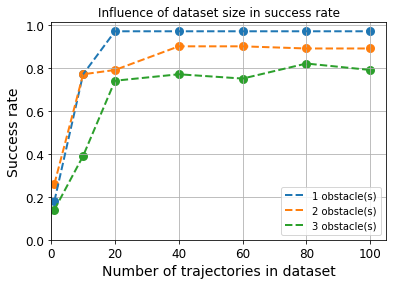

In [166]:
n_trajectories_list = [1, 10, 20, 40, 60, 80, 100]
n_obstacles_list = [1, 2, 3]

for i in range(len(n_obstacles_list)):
    plt.plot(n_trajectories_list, success_rate_list[i], linestyle='--', linewidth=2, label=('%i obstacle(s)' % (i+1)))
    plt.scatter(n_trajectories_list, success_rate_list[i], linewidth=3)
    
plt.grid('on')
plt.xlabel('Number of trajectories in dataset')
plt.ylabel('Success rate')
plt.title('Influence of dataset size in success rate')
plt.ylim(ymin=0)
plt.xlim(xmin=0)
plt.legend()
plt.show()

**4.23)** We can observe that increasing the dataset size will increase the performance of the classifier in environments with 1, 2, and 3 obstacles. This performance, however, seems to be bounded (and this bound gets lower as the number of obstacles increases), which suggests that adding more data will not be enough to completely solve this problem. Why do you think this is the case?

Answer : The problme may arise from the fact that our model if to simple for the complexity of the path to be achived. When a model is underfitting the data, adding more data is not going to increase the performance of the algorithm. maybe it can help to add the size of the obtacles to the features space, so that the training can also include this feature and add an extra layer of complexity. But this is just a guess

**4.24)** In the motivation of this problem, we mentioned that Imitation Learning can be used to learn from humans. However, from this plot, we can observe that as the problem gets more complex (more obstacles in this case), more data is required to find good solutions. More data means more human time to generate the demonstrations, and human time is expensive.

What limitations do you see in the approach that we used in this assignment to solve the motion planning problem?

Answer : One of the main limitations is due to the computational time of training the robot on different environments.
If the number of obstacles grows, the number of examples that are necessary for training the algorithm can grow considerably. IN addition to that, one the problem is that the more complex the path, the more training data are necessary to train the model on different situations. IN order to achieve a sound training it is important to cover a sufficinetly variable space of cases, that becames cumber some to work with as the number of obstacles grows.

Another point is related to the shape or size of the obstacles. The problem is that here we always used obstacles of the same size. But what happens if there obstacles have also different sizes and shapes? the number of training instances grows even more.



That's it! Congratulations for reaching the end of this practicum :)